## Try to get the trial matrix for  2 sec before or after the lever Press 

1. This is a copy of the TrialMatrix_leverPress_5.ipynb

To create the trial Matrix instead of select the based on interval atLever, just select 2 secs before or after the leverPress independent of the location of the animal

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run ../setup_project.py
%run ../neuronAutopi.py

%run ../generic_plot_functions.py
import os.path
from spikeA.Dat_file_reader import Dat_file_reader
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy import integrate
from scipy.ndimage import gaussian_filter1d 
import os
from itertools import product
from scipy.stats import pearsonr
from scipy import signal

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [2]:
prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|████████████████████████████████████████████████████████████████| 180/180 [04:21<00:00,  1.45s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [3]:
for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
    getSearchHomingIntervals(ses,sSes)

180it [00:05, 34.83it/s]


In [4]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    return sSes,ses,n, nid 


## Get the leverPress time and plot the time of spikes in regard to the leverPress on the path 

In [5]:
%%time
fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)

LeverPressinRestime= res[res.sessionName== sSes.name].levertimeRes.values
LeverPressinRestime.shape, len(ses.trials)


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 121 ms, sys: 7.64 ms, total: 129 ms
Wall time: 155 ms


((114,), 115)

In [6]:
#levercLid= list(cells[(cells.leverCell_all_light) & (cells.usable_auto_RF) & (cells.leverCell_all_dark== False)].cluId)
#levercDid= list(cells[(cells.leverCell_all_dark) & (cells.usable_auto_RF) & (cells.leverCell_all_light== False) ].cluId)


## create the IFRstacked around leverPress for all the cells in one session 

In [7]:
def samples2time(l):
    return bin_size_sec*(np.arange(l)-l/2+.5)

In [10]:
def get_stacked_ifr_all_cropped(sSes,ses):
    session_trials = res[(res.sessionName == sSes.name) & (res.valid==True)].sort_values(by='trialNo')
    LeverPressinRestime = session_trials.levertimeRes.values
    
    atLever_times = np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']])
    
    
    
    trial_lever_times = []
    # loop through trials in the same order as trial dataframe "session_trials"
    for i,LeverPress in enumerate(LeverPressinRestime):
        # find atLever time interval for given trial
        found = False
        for (start,end) in atLever_times:
            if start <= LeverPress <= end:
                found = True
                break
        if not found:
            # raise IOError("not found")
            continue
        if found:
            #print("trial",i,"LeverPress",LeverPress,"occurs within",start,end) # keep the index of trial so we can reference in case one is not found
            trial_lever_times.append({'trial_id': i, 'start': start, 'end': end, 'LeverPress': LeverPress})
            
            
            
    atLeverIFR_trials = [] # number of trials * number of cells * time

    for t in trial_lever_times:
        start,end = t['start'],t['end']

        # IFR around lever for each trial
        atLeverifr = [] # number of cells * time

        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(np.array([start,end]))
            n.spike_train.instantaneous_firing_rate(bin_size_sec=bin_size_sec, sigma=sigma, time_start=start, time_end=end, outside_interval_solution="remove")
            n.spike_train.ifr[0][n.spike_train.ifr[0] > 80] = 0
            atLeverifr.append(n.spike_train.ifr[0])
        atLeverifr = np.array(atLeverifr) # number of cells * trial duration
        atLeverIFR_trials.append(atLeverifr)
        
        
    # get time before and after leverpress for aligned stack
    dt=[]
    for t in trial_lever_times:
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        dt.append(max(leverpress-start, end-leverpress))
    maxtime = np.max(dt)
    
    time_samples = int(np.ceil(maxtime/bin_size_sec)) # before and after lever press


    # stack : trials * time * cells
    # time aligning is by trial

    ncells = len(sSes.cg.neuron_list)
    ntrials = len(trial_lever_times)
    stackedifr_cells = np.zeros((ntrials, ncells, time_samples*2))
    stackedifr_cells[:] = np.nan # pad empty space with nan

    for i, (atLeverifr, t) in enumerate(zip(atLeverIFR_trials, trial_lever_times)):
        # print('trial',i,t,'/',"IFR shape:",atLeverifr.shape)
        # align trials
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        left_pad_samples = time_samples - int(np.ceil((leverpress-start)/bin_size_sec)) # how many nans to add before start (for this trial, all cells), so that lever press is centered
        stackedifr_cells[i,:,left_pad_samples:left_pad_samples+atLeverifr.shape[1]] = atLeverifr

    trial_ids = np.array([t['trial_id'] for t in trial_lever_times])
    # mask for light or dark
    trial_light = (session_trials.light == 'light').values
    trial_light_onids = trial_light[trial_ids]

    trials_light_ids = np.where(trial_light_onids)[0]
    trials_dark_ids = np.where(~trial_light_onids)[0]
    
    ###############
    #### Crop the stack 0.5 second before and after the leverPress to remove Nans 
    ##############
    time = samples2time(time_samples*2)

    # crop
    samples_to_keep = 50 #100
    indx0,indx1 = len(time)//2-samples_to_keep//2, len(time)//2+samples_to_keep//2
    time_scaled = time[indx0:indx1]
    stackedifr_cells = stackedifr_cells[:,:,indx0:indx1]
    #time, stackedifr_cells.shape

    #return stackedifr_cells, trials_light_ids, trials_dark_ids, time, time_scaled 
    return stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled 

In [11]:
def clean_stack(stack):
        return stack[~np.isnan(stack).any(axis=1)]
    
def plot_stackedifr_oneCell(gs, stackedifr_cells, cindx, trials_light_ids, trials_dark_ids, legend=True, bbox_to_anchor=(1.35, 1), nonan=True):
        
    # For light trials
    ax = fig.add_subplot(gs[0])
    stackedifr_light = stackedifr_cells[trials_light_ids, cindx, :]
    if nonan:
        stackedifr_light = clean_stack(stackedifr_light)
        cat = ax.pcolor(stackedifr_light)
        ax.set_title(f"nid:{cindx} -{'light'}\n{'remove Nans'}", fontsize=9)
    else: 
        cat = ax.pcolor(stackedifr_light)
        ax.set_title(f"nid:{cindx} -{'light'}", fontsize=9)
    
    # Modify the x-axis
    xticks_positions = [0, stackedifr_light.shape[1] // 2, stackedifr_light.shape[1] - 1]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels([-0.5, 0, 0.5])
    ax.set_xlabel("time relative \n to lever press [s]")
    ax.set_ylabel("Trials")

    # Add red vertical dashed line at 0
    ax.axvline(xticks_positions[1], color='red', linestyle='--', label="at lever press")
    fig.colorbar(cat, ax=ax)

    # For dark trials
    ax = fig.add_subplot(gs[1])
    stackedifr_dark = stackedifr_cells[trials_dark_ids, cindx, :]
    if nonan:
        stackedifr_dark = clean_stack(stackedifr_dark)
        cat = ax.pcolor(stackedifr_dark)
        ax.set_title(f"nid:{cindx} -{'dark'}\n{'remove Nans'}", fontsize=9)
    else: 
        cat = ax.pcolor(stackedifr_dark)
        ax.set_title(f"nid:{cindx} -{'dark'}", fontsize=9)
    
    xticks_positions = [0, stackedifr_dark.shape[1] // 2, stackedifr_dark.shape[1] - 1]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels([-0.5, 0, 0.5])
    ax.set_xlabel("time relative \n to lever press [s]")
    ax.set_ylabel("Trials")

    # Add red vertical dashed line at 0
    ax.axvline(xticks_positions[1], color='red', linestyle='--', label="leverPress")
    fig.colorbar(cat, ax=ax)
    
    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor)

Now get the expected values

In [12]:
def expected_value(v,w):
    indxs=np.isfinite(v)&np.isfinite(w)
    return np.average(v[indxs],weights=w[indxs])

def plot_expected_value(ax, stackedifr_cells,trials_light_ids,cindx, light= 'light', nonan= False):
    
    #ax= fig.add_subplot(gs[0])
    ifrstack= stackedifr_cells[trials_light_ids,cindx,:]

    if nonan:
        ifrstack=  ifrstack[~np.isnan(ifrstack).any(axis=1)]
    
    s0 = np.nanmean(ifrstack, axis=(0)) # axis: trials * 1 neuron
    t_mean = expected_value(time_scaled,s0) ## averaged expected_value 
    print(t_mean)
    l = ax.plot(time_scaled,s0,label='{} {}'.format(light, cindx))
    ax.axvline(t_mean, c='green', lw=1.5, label="leverPress")
    ax.axvline(0,linestyle='--', c='red', lw=1.0, label="leverPress")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("relative time to \n lever press [s]")
    ax.set_ylabel("sum of firing rate [Hz] \n  of all trials")
    ax.set_title(f"{light} \n exp_val:{t_mean:.3f} " , fontsize= 9)

def plot_expValues_oneCell(gs, stackedifr_cells, trials_light_ids, trials_dark_ids,  nonan= False):

    for i, (l,light_inx) in enumerate(zip(['light', 'dark'], [trials_light_ids, trials_dark_ids])):
        ax= fig.add_subplot(gs[i])
        plot_expected_value(ax, stackedifr_cells,light_inx,cindx, light= l,  nonan= nonan)

In [13]:
bin_size_sec = 0.02
sigma=1

ses= myProject.sessionList[15]
sSes= sSessions[15]

In [14]:
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

We have some trials that although they are labeled as valid trials but the leverPress is Nan .. we see a difference between length of trials 

stackedifr_cells: FinalValidTrials* numCells* 50 samples 

In [15]:
stackedifr_cells.shape, len(sSes.cg.neuron_list), np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']]).shape 

((113, 46, 50), 46, (120, 2))

0.019180505404830524
0.022968904402051977
0.017567062894583964
0.03629496470162144


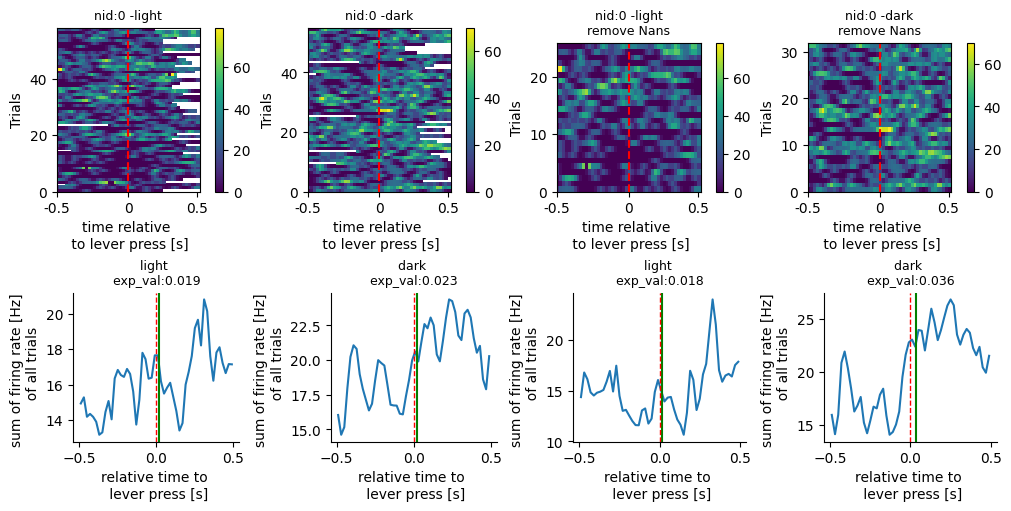

In [16]:
col=4
row=2
sizePerRow, sizePerCol = 2.5,2.5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row,col, figure=fig, wspace= 0.8) # all our figure

cindx= 0

gs0= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,:2])#, width_ratios=[1.5,2,1,1])
plot_stackedifr_oneCell(gs0, stackedifr_cells,cindx,trials_light_ids,trials_dark_ids, legend= False, bbox_to_anchor= (1.45,1), nonan=False)

gs1= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,:2])#, width_ratios=[1.5,2,1,1])
plot_expValues_oneCell(gs1, stackedifr_cells, trials_light_ids, trials_dark_ids, nonan= False)


gs2= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,2:])#, width_ratios=[1.5,2,1,1])
plot_stackedifr_oneCell(gs2, stackedifr_cells,cindx,trials_light_ids,trials_dark_ids, legend= False, bbox_to_anchor= (1.45,1), nonan=True)

gs3= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,2:])#, width_ratios=[1.5,2,1,1])
plot_expValues_oneCell(gs3, stackedifr_cells, trials_light_ids, trials_dark_ids, nonan= True)

### Get multiple cells for example all fs and grid cells together 

In [17]:
ses= myProject.sessionList[10]
sSes= sSessions[10]

In [18]:
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

In [19]:
def plot_cellTypes_expValues(ax, sSes, trials_light_ids, trials_dark_ids, stackedifr_cells, bbox_to_anchor=(1.5, 1.0), legend=True, nonan=False):
    
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values

    cell_filters = [fsin_indx, gc_indx]
    cell_filters_str = ['FSIN', 'GC']

    light_conditions = [trials_light_ids, trials_dark_ids]
    light_conditions_str = ['light', 'dark']

    neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))

    # Normalize the data
    stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)

    expvals = []
    for light_condition, light_condition_str in zip(light_conditions, light_conditions_str):
        for cell_filter, cell_filter_str in zip(cell_filters, cell_filters_str):
            ifrstack = stackedifr_cells_normalized[light_condition][:, cell_filter]
            if nonan: 
                ifrstack= ifrstack[~np.isnan(ifrstack).any(axis=(1,2))]
            #print(ifrstack.shape)
            s0 = np.nanmean(ifrstack, axis=(0, 1))  # Mean across trials and neurons
            t_mean = expected_value(time_scaled, s0)  # Calculate expected value
            expvals.append(t_mean)
            l = ax.plot(time_scaled, s0, label='{} {}'.format(light_condition_str, cell_filter_str))
            ax.axvline(t_mean, c=l[0].get_color(), lw=1, alpha=0.6)

    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor)

    exvalsDiff = expvals[0] - expvals[1]
    ax.set_title(f"Mean by cell types\nFSExpVal-gcExpVal:{exvalsDiff:.3f}", fontsize=9)
    if nonan: 
        ax.set_title(f"Mean by cells & trials\n FSExpVal-gcExpVal:{exvalsDiff:.3f}\n {'Remove Nans'}", fontsize=9)
    else: 
        ax.set_title(f"Mean by cells & trials\n FSExpVal-gcExpVal:{exvalsDiff:.3f}\n fs:{sum(fsin_indx)}, gc:{sum(gc_indx)}", fontsize=9)
        
    ax.set_xlabel("time relative to \n lever press [s]", fontsize=9)
    ax.set_ylabel("mean firing rate [Hz]", fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [20]:
def plot_compare_allCells_expVal(gs, sSes, stackedifr_cells, trials_light_ids, light= 'light'):
    
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values
    
    stacked_ifr_fs= stackedifr_cells[trials_light_ids][:,fsin_indx] # use raw
    stacked_ifr_gc= stackedifr_cells[trials_light_ids][:,gc_indx] # use raw

    stacked_ifrs = [stacked_ifr_fs, stacked_ifr_gc] 
    cell_types = ['FS', 'gc']
    light_conditions = [light, light] 
    # Loop through the light conditions and cell types
    for i, (light, ctype, stacked_ifr) in enumerate(zip(light_conditions, cell_types, stacked_ifrs)):
        ax = fig.add_subplot(gs[i])
        if ctype== 'FS':
            ax.plot(time_scaled, np.nanmean(stacked_ifr, axis=0).T, alpha= 0.6)
        else: 
            ax.plot(time_scaled, np.nanmean(stacked_ifr, axis=0).T, alpha= 0.6)
        ax.set_xlabel("time relative to \n lever press [s]", fontsize=9)
        ax.set_ylabel("mean firing rate [Hz]", fontsize=9)
        ax.set_title(f'{ctype}_{light}', fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

In [21]:
def Compare_nans_withoutnan(gs):

    # Define the parameters for looping
    plot_configs = [
        {'subplot_index': 0, 'legend': False, 'nonan': False},
        {'subplot_index': 1, 'legend': True, 'nonan': True}
    ]

    # Loop through the configurations and plot
    for config in plot_configs:
        ax = fig.add_subplot(gs[config['subplot_index']])
        plot_cellTypes_expValues(ax, sSes,trials_light_ids, trials_dark_ids, stackedifr_cells, bbox_to_anchor=(1.5, 1.0), legend=config['legend'], nonan=config['nonan'] )

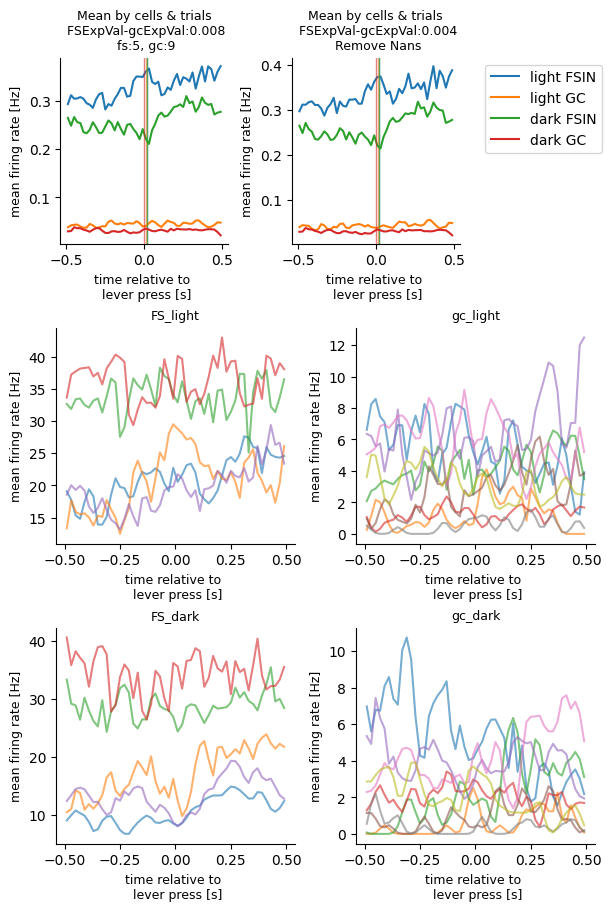

In [22]:
col=2
row=3
sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row,col, figure=fig, wspace= 0.1) # all our figure

gs0= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,:])#, width_ratios=[1.5,2,1,1])
Compare_nans_withoutnan(gs0)

gs1= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,:])#, width_ratios=[1.5,2,1,1])
plot_compare_allCells_expVal(gs1, sSes, stackedifr_cells, trials_light_ids, light= 'light')

gs2= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2,:])#, width_ratios=[1.5,2,1,1])
plot_compare_allCells_expVal(gs2, sSes, stackedifr_cells, trials_dark_ids, light= 'dark')

It seems that there is a sub-population of FS interneurons that has a peak and this peak changes per light condition

try with another session 

In [23]:
ses= myProject.sessionList[152]
sSes= sSessions[152]

stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

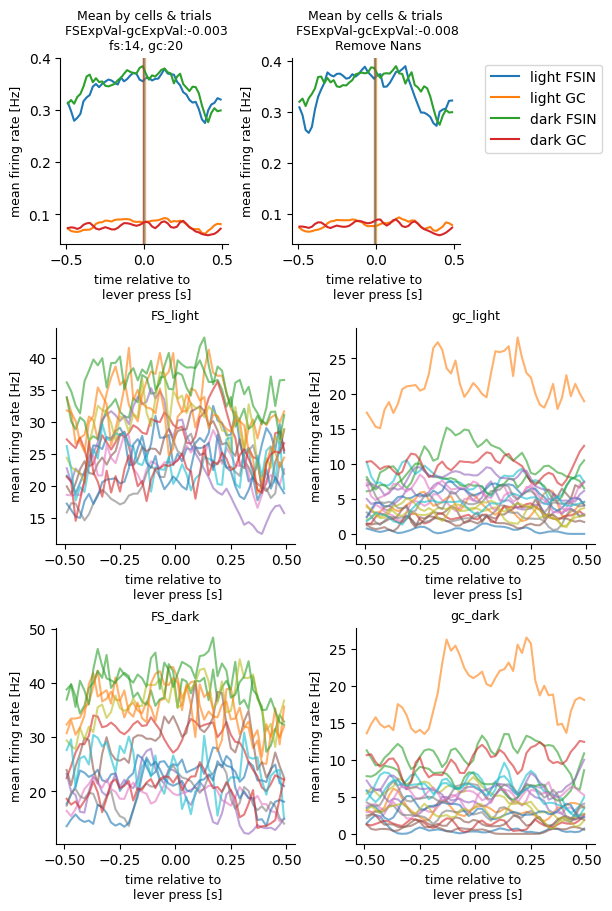

In [24]:
col=2
row=3
sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row,col, figure=fig, wspace= 0.1) # all our figure

gs0= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,:])#, width_ratios=[1.5,2,1,1])
Compare_nans_withoutnan(gs0)

gs1= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,:])#, width_ratios=[1.5,2,1,1])
plot_compare_allCells_expVal(gs1, sSes, stackedifr_cells, trials_light_ids, light= 'light')

gs2= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2,:])#, width_ratios=[1.5,2,1,1])
plot_compare_allCells_expVal(gs2, sSes, stackedifr_cells, trials_dark_ids, light= 'dark')

## Run the function for all sessions 

In [25]:
get_stacked_ifr_all_sessions = [get_stacked_ifr_all_cropped(sSes,ses) for sSes,ses in tqdm(zip(sSessions,myProject.sessionList))]

180it [04:05,  1.37s/it]


In [26]:
len(get_stacked_ifr_all_sessions)

180

In [28]:
sSesNames = []
numgcs = []
numfs = []
gc_indxs = []
fsin_indxs = []

stacked_ifr_fsls = []
stacked_ifr_fsds = []
stacked_ifr_gcds = []
stacked_ifr_gcls = []
stackedifr_cellss_normalized = []
times = []
times_scaled = []
expvalsls = []
expvalsds = []

for sSes, stack in zip(sSessions, get_stacked_ifr_all_sessions[:]):
    sSesNames.append(sSes.name)
    stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]
    
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values
    
    numgcs.append(sum(gc_indx))
    numfs.append(sum(fsin_indx))
    gc_indxs.append(gc_indx)
    fsin_indxs.append(fsin_indx)
    #times.append(time)
    times_scaled.append(time_scaled)
    
    stacked_ifr_fsls.append(stackedifr_cells[trials_light_ids][:, fsin_indx])
    stacked_ifr_gcls.append(stackedifr_cells[trials_light_ids][:, gc_indx])
    
    stacked_ifr_fsds.append(stackedifr_cells[trials_dark_ids][:, fsin_indx])
    stacked_ifr_gcds.append(stackedifr_cells[trials_dark_ids][:, gc_indx])
    
    cell_filters = [fsin_indx, gc_indx]
    light_conditions = [trials_light_ids, trials_dark_ids]
    neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))
    
    with np.errstate(invalid='ignore'):
        stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)
    
    expvalsl = []
    expvalsd = []
    light_conditions = [trials_light_ids, trials_dark_ids]
    light_conditions_str = ['light', 'dark']
    
    for light_condition, light_condition_str in zip(light_conditions, light_conditions_str):
        for cell_filter, cell_filter_str in zip(cell_filters, ['FSIN', 'GC']):
            ifrstack = stackedifr_cells_normalized[light_condition][:, cell_filter]
            if ifrstack.shape[1] != 0:
                s0 = np.nanmean(ifrstack, axis=(0, 1))
                t_mean = expected_value(time_scaled, s0)
                if light_condition_str == 'light':
                    expvalsl.append(t_mean)
                else:
                    expvalsd.append(t_mean)
    
    # Ensure expvalsl and expvalsd have at least two elements
    if len(expvalsl) < 2:
        expvalsl.extend([np.nan] * (2 - len(expvalsl)))
    if len(expvalsd) < 2:
        expvalsd.extend([np.nan] * (2 - len(expvalsd)))

    # Append to expvalsls and expvalsds lists only once per session
    expvalsds.append(expvalsd)
    expvalsls.append(expvalsl)

# Now create the DataFrame
data = {
    'ses': sSesNames,
    'gc_num': numgcs,
    'fs_num': numfs,
    #'stackedifr_cells': stackedifr_cells,
    'stacked_ifr_fsls': stacked_ifr_fsls,
    'stacked_ifr_fsds': stacked_ifr_fsds,
    'stacked_ifr_gcls': stacked_ifr_gcls,
    'stacked_ifr_gcds': stacked_ifr_gcds,
    'time_scaleds': times_scaled,
    'expvalsds_fs': [vals[0] for vals in expvalsds],  # Extract FSIN expvals for each session
    'expvalsds_gc': [vals[1] for vals in expvalsds],  # Extract GC expvals for each session
    'expvalsls_fs': [vals[0] for vals in expvalsls],  # Extract FSIN expvals for each session
    'expvalsls_gc': [vals[1] for vals in expvalsls],  # Extract GC expvals for each session
}

df = pd.DataFrame(data)


Sanity check, if everything makes sense:

In [29]:
for k in data.keys():
    print(len(data[k]), k)

180 ses
180 gc_num
180 fs_num
180 stacked_ifr_fsls
180 stacked_ifr_fsds
180 stacked_ifr_gcls
180 stacked_ifr_gcds
180 time_scaleds
180 expvalsds_fs
180 expvalsds_gc
180 expvalsls_fs
180 expvalsls_gc


In sessions where there is no fs or gc, the expvalsds_fs or expvalsds_gc should be nan and the corresponding 'data['fs_num']' or data['gc_num'] should be zero 

In [30]:
df.keys()

Index(['ses', 'gc_num', 'fs_num', 'stacked_ifr_fsls', 'stacked_ifr_fsds',
       'stacked_ifr_gcls', 'stacked_ifr_gcds', 'time_scaleds', 'expvalsds_fs',
       'expvalsds_gc', 'expvalsls_fs', 'expvalsls_gc'],
      dtype='object')

In [31]:
df

,ses,gc_num,fs_num,stacked_ifr_fsls,stacked_ifr_fsds,stacked_ifr_gcls,stacked_ifr_gcds,time_scaleds,expvalsds_fs,expvalsds_gc,expvalsls_fs,expvalsls_gc
0,mn8578-30112021-0107,0,0,"[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",NaN,NaN,NaN,NaN
1,mn8578-05122021-0108,7,1,"[[[6.063891887664795, 5.848990440368652, 24.21...","[[[22.89508819580078, 24.42542839050293, 25.34...","[[[2.9278409481048584, 12.105263710021973, 19....","[[[17.504377365112305, 15.026412963867188, 20....","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",0.016763,0.009698,0.022739,0.023122
2,mn8578-06122021-0107,6,1,"[[[56.242889404296875, 54.69916534423828, 27.3...","[[[32.27402877807617, 15.026412963867188, 5.62...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",0.028421,0.011260,0.039065,0.051468
3,mn8578-07122021-0107,2,3,"[[[34.75199508666992, 15.026412963867188, 3.14...","[[[29.831233978271484, 17.725969314575195, 20....","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.006691531278192997, 0...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",0.007667,0.147586,-0.002759,0.086108
4,mn8578-08122021-0110,5,3,"[[[0.0, 62.105262756347656, 40.815887451171875...","[[[50.44318771362305, 55.605613708496094, 44.6...","[[[0.0, 62.105262756347656, 40.815887451171875...","[[[50.44318771362305, 55.605613708496094, 44.6...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",-0.010525,0.007566,-0.002596,0.008898
...,...,...,...,...,...,...,...,...,...,...,...,...
175,jp499-23052023-0108,0,5,"[[[0.22159308195114136, 0.006691531278192997, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",0.026443,NaN,-0.004878,NaN
176,jp499-24052023-0108,1,9,"[[[22.88170623779297, 24.42542839050293, 25.34...","[[[27.11829376220703, 40.12263107299805, 24.20...","[[[39.89434814453125, 24.197145462036133, 5.39...","[[[2.699556350708008, 12.098572731018066, 19.9...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",0.014525,0.024139,0.006215,0.026174
177,jp499-16052023-0108,0,0,"[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",NaN,NaN,NaN,NaN
178,jp499-18052023-0108,2,4,"[[[52.92115020751953, 62.32685852050781, 72.64...","[[[39.45184326171875, 57.84191131591797, 61.87...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",-0.005036,0.050098,-0.009474,0.078825


In [32]:
# Assuming your original DataFrame is named `df`
# Create lists to hold the new DataFrame data
sessions = []
light = []
gc_num = []
fs_num = []
ctype = []
expval = []
firingType = []

# Define the light conditions and ctypes
light_conditions = ['dark', 'dark', 'light', 'light']
ctypes = ['fs', 'gc', 'fs', 'gc']

# Iterate over each row in the original DataFrame
for index, row in df.iterrows():
    # For each session, extract and append values based on conditions
    for i in range(4):
        sessions.append(row['ses'])
        light.append(light_conditions[i])
        gc_num.append(row['gc_num'])
        fs_num.append(row['fs_num'])
        ctype.append(ctypes[i])
        
        # Determine the correct expval based on ctype and light
        if ctype[i] == 'fs':
            if light_conditions[i] == 'light':
                current_expval = row['expvalsls_fs']
            else:
                current_expval = row['expvalsds_fs']
        else:  # ctype[i] == 'gc'
            if light_conditions[i] == 'light':
                current_expval = row['expvalsls_gc']
            else:
                current_expval = row['expvalsds_gc']

        expval.append(current_expval)
        
        # Determine the firingType based on the expval
        if current_expval > 0 and current_expval!= np.nan:
            firingType.append('after')
        elif current_expval < 0 and current_expval!= np.nan:
            firingType.append('before')
        else: 
            firingType.append(np.nan)
# Create the new DataFrame
df2 = pd.DataFrame({
    'sessions': sessions,
    'light': light,
    'gc_num': gc_num,
    'fs_num': fs_num,
    'ctype': ctype,
    'expval': expval,
    'firingType': firingType
})

In [33]:
df2

,sessions,light,gc_num,fs_num,ctype,expval,firingType
0,mn8578-30112021-0107,dark,0,0,fs,NaN,NaN
1,mn8578-30112021-0107,dark,0,0,gc,NaN,NaN
2,mn8578-30112021-0107,light,0,0,fs,NaN,NaN
3,mn8578-30112021-0107,light,0,0,gc,NaN,NaN
4,mn8578-05122021-0108,dark,7,1,fs,0.016763,after
...,...,...,...,...,...,...,...
715,jp499-18052023-0108,light,2,4,gc,0.078825,after
716,jp499-25052023-0108,dark,2,5,fs,0.008470,after
717,jp499-25052023-0108,dark,2,5,gc,0.128974,after
718,jp499-25052023-0108,light,2,5,fs,0.007458,after


In [34]:
import itertools
from statannotations.Annotator import Annotator

def get_list_of_pairs_element_first(elementList, conditionList):
    holder = []
    for element in elementList:
        for first, second in itertools.combinations(conditionList, 2):
            holder.append(((first, element), (second, element)))
    return holder

def get_list_of_pairs_condition_first(elementList, conditionList):
    holder = []
    for condition in conditionList:
        for first, second in itertools.combinations(elementList, 2):
            holder.append(((condition, first), (condition, second)))
    return holder

/home/maryam/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

fs_light vs. gc_light: Mann-Whitney-Wilcoxon test two-sided, P_val:8.332e-05 U_stat=6.575e+03
fs_dark vs. gc_dark: Mann-Whitney-Wilcoxon test two-sided, P_val:3.617e-04 U_stat=6.814e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

fs_light vs. gc_light: Wilcoxon test (paired samples), P_val:8.392e-04 Stat=1.100e+01


/tmp/ipykernel_853601/897991667.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mydf2= df2.groupby(['subject', 'light','ctype']).median().reset_index()


fs_dark vs. gc_dark: Wilcoxon test (paired samples), P_val:6.561e-04 Stat=1.000e+01


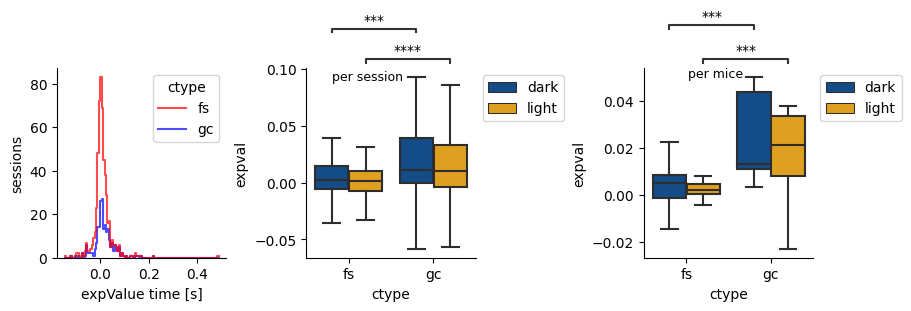

In [35]:
# Define the colors for the plots
hue_colors_hist = {'fs': 'red', 'gc': 'blue'}  # Red for fs, blue for gc
hue_colors_box = {'dark': '#004c99', 'light': '#ffaa00'}  # Dark blue for light, dark yellow for dark in boxplot

# Plot settings
col = 3
row = 1
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

# First subplot: Histogram
ax = fig.add_subplot(gs[0])
sns.histplot(data=df2, x="expval", hue="ctype", multiple="stack", log_scale=False, element="step", fill=False, ax=ax, palette=hue_colors_hist, alpha= 0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('expValue time [s]')
ax.set_ylabel('sessions')

# Second subplot: Boxplot
ax = fig.add_subplot(gs[1])
order = ['fs', 'gc']
b = sns.boxplot(data=df2, x='ctype', y="expval", hue="light", order=order, dodge=True, showfliers=False, ax=ax, palette=hue_colors_box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.text(-0.2, 0.09, 'per session', fontsize= 9)

pairs = get_list_of_pairs_element_first(['light', 'dark'], order)

annot = Annotator(b, pairs, data=df2, x='ctype', y="expval", order=order, hue="light")
annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annot.apply_test()
ax, test_results = annot.annotate()

#plt.show()

ax= fig.add_subplot(gs[2])
df2['subject']= [ ses.split('-')[0] for ses in df2.sessions]
mydf2= df2.groupby(['subject', 'light','ctype']).median().reset_index()
b = sns.boxplot(data=mydf2, x='ctype', y="expval", hue="light", order=order, dodge=True, showfliers=False, ax=ax, palette=hue_colors_box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.text(0.02, 0.05, 'per mice', fontsize= 9)

pairs = get_list_of_pairs_element_first(['light', 'dark'], order)

annot = Annotator(b, pairs, data=mydf2, x='ctype', y="expval", order=order, hue="light")
annot.configure(test='Wilcoxon', text_format='star', loc='outside', verbose=2) # Mann-Whitney
annot.apply_test()
ax, test_results = annot.annotate()

In [36]:
mydf2


,subject,light,ctype,gc_num,fs_num,expval
0,jp1084,dark,fs,2.0,2.0,-0.002724
1,jp1084,dark,gc,2.0,2.0,0.006981
2,jp1084,light,fs,2.0,2.0,0.004339
3,jp1084,light,gc,2.0,2.0,0.010630
4,jp1684,dark,fs,3.0,1.5,0.000689
...,...,...,...,...,...,...
63,mn8578,light,gc,5.5,3.0,0.021077
64,mn8599,dark,fs,2.0,3.5,-0.001390
65,mn8599,dark,gc,2.0,3.5,0.011520
66,mn8599,light,fs,2.0,3.5,0.000281


## Define a function that calculates the peak_to_baseline_diff for each cell:

In [37]:
def get_peak_to_baseline(stackedifr_cells, cind,time_scaled ):
    
    arr= np.nanmean(stackedifr_cells[:,cind,:], axis=0).T
    
    # Step 1: Find the index of the highest peak
    peak_index = np.argmax(arr)
    peak_value = arr[peak_index]

    # Step 2: Calculate the baseline mean
    # The baseline is calculated from the start up to (but not including) the peak
    baseline_mask = time_scaled < time_scaled[peak_index]
    baseline_values = arr[baseline_mask]
    baseline_mean = np.mean(baseline_values)

    # Step 3: Compare peak height to the baseline
    peak_to_baseline_diff = peak_value - baseline_mean
    
    return arr, peak_index, baseline_mean, peak_to_baseline_diff

def plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_baseline_diff, text_pos= [-0.4, 32], legend= True):
    ax.plot(time_scaled, arr)
    ax.axvline(time_scaled[peak_index], color='r', linestyle='--', label=f'Peak')
    #ax.set_ylim(0,30)
    ax.set_ylabel('Firing rate Hz')
    ax.set_xlabel('Relative time \n to lever press [s]')
    ax.axhline(baseline_mean, color='g', linestyle='--', label=f'Baseline mean')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.text(text_pos[0],text_pos[1], f'Peak_to_baseline:{peak_to_baseline_diff:.2f}\n peak at:{time_scaled[peak_index]:.2f}\n Baseline mean :{baseline_mean:.2f}')
    #plt.show()

Run on a single cell

In [38]:
ses= myProject.sessionList[10]
sSes= sSessions[10]

In [39]:
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

In [40]:

session_cells = cells[(cells.session == sSes.name)]
gc_indx = session_cells.gridCell_FIRST.values
fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values

stacked_ifr_fs= stackedifr_cells[trials_light_ids][:,fsin_indx] # use raw
stacked_ifr_gc= stackedifr_cells[trials_light_ids][:,gc_indx] # use raw


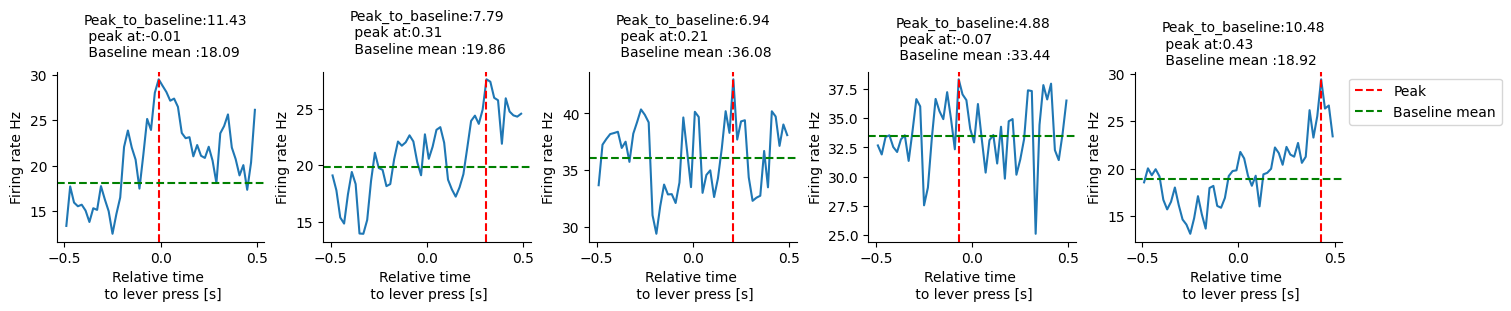

In [41]:
# Plot settings
col = 5
row = 1
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

# Define the positions and text positions for each subplot
cinds = [1, 0, 3, 2, 4]  # Example cind values to loop through (0 to 4)
text_positions = [[-0.4, 32], [-0.4, 30], [-0.4, 45], [-0.4, 40], [-0.4, 31]]  # Example positions for text

for i, cind in enumerate(cinds):
    # Create subplot
    ax = fig.add_subplot(gs[i])
    
    # Get data for the current cind
    arr, peak_index, baseline_mean, peak_to_baseline_diff = get_peak_to_baseline(stacked_ifr_fs, cind, time_scaled)
    
    # Plot the data
    plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_baseline_diff,
                              text_pos=text_positions[i], legend=(i == 4))  # Legend only for the third plot


## Get the 2dmap of this cell in different conditions

In [42]:
def get_LeverCrossCorr(cid,res, bin_size_sec= 0.02 , min_sec= -3 , max_sec=3 , cond= 'atLever_light', light='light'):
    
    ### first get the res time of the lever press
    sSes,ses,n, nid= get_sSesId_nId(cid)
    LeverPressinRestime= res[(res.sessionName== sSes.name) & (res.light== light)].levertimeRes.values
    
    ### now get the cross_corr
    histStack=[]
    timestampStack=[]
    mRate=[]
    for i, n in enumerate(sSes.cg.neuron_list):
        n.spike_train.set_intervals(ses.intervalDict[cond])
        rate= n.spike_train.mean_firing_rate()
        hist,ran= n.spike_train.spike_time_crosscorrelation(st1= LeverPressinRestime, st2=n.spike_train.st , 
                                                            bin_size_sec= bin_size_sec , min_sec= min_sec , max_sec=max_sec )
        timestamp = n.spike_train.mid_point_from_edges(ran)
        histStack.append(hist)
        timestampStack.append(ran)
        mRate.append(rate)
    
    histStack= np.stack(histStack,axis=0)
    timestampStack= np.stack(timestampStack, axis=0)
    mRate= np.stack(mRate, axis=0)
    return histStack, timestampStack , mRate , nid

def plotmap(axes, cluId, maps, condition= 'circ80_1', showYLabel=True):
    mapindex=cells[cells.cluId==cluId].cluId
    #print(mapindex,mapindex.index)
    im=maps[condition][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='jet',interpolation=None)
    axes.set_title(f'{condition} \n {np.round(np.nanmax(im),2)} Hz',pad=3,y=0.99, fontsize=10)
    #axes.axis('off')
    #if showYLabel:
    #    axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

def plotLeverMap(axes, cluId, maps, df_HDInfoSingle, condition='all_light', r='none', showYLabel=True):
    nCells = maps["map"]["all_light"]["none"]['data'].shape[0]

    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break

    im = mapToPlot
    Lscore = df_HDInfoSingle[(df_HDInfoSingle.cluid == cluId) & (df_HDInfoSingle.light == condition)]['HD_score'].iloc[0]
    im = im[:, ~np.isnan(im).all(axis=0)]
    im = im[~np.isnan(im).all(axis=1), :]
    axes.imshow(im.T, origin="lower", cmap='jet', interpolation=None)
    
    if condition == 'all_light':
        condname = 'light'
    elif condition == 'all_dark':
        condname = 'dark'
        
    if r == 'none':
        rname = 'lever-location'
    else:
        #rname = 'arenaref'
        rname = 'cardinal'
    
    if r=='none':
        
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz\nmvl: {Lscore:.2f}\n{condname} - {rname}', fontsize=9)
    else:
        #axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} - {rname}', fontsize=10)
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} ', fontsize=10)
    axes.axis('off')
    
def plot_multiple_lever_maps(gs, cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs, colSize=1.8, rowSize=1.8):
    for i, condition in enumerate(conditions):
        for j, r in enumerate(rs):
            ax = fig.add_subplot(gs[0, i*len(rs) + j])
            plotLeverMap(ax, cellIdToPlot, myLeverMaps, df_HDInfoSingle, condition=condition, r=r)

            
def get_spikePosi_atLever(n, sSes, ses, maxDistance= 30, rotationType='none',
                     invalidateSmallBridgeAngle= False ,invalidateMaxAngle=np.pi/12, cond= 'atLever_dark', smoothing= True):

    sSes.ap.load_pose_from_file() # get original hd data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    # transform the coordinate system of the position data, in setup_project.py
    toLeverReferenceFrame(ses=ses,sSes=sSes,maxDistance=maxDistance, rotationType=rotationType,
                         invalidateSmallBridgeAngle=invalidateSmallBridgeAngle,invalidateMaxAngle=invalidateMaxAngle)
    sSes.ap.set_intervals(ses.intervalDict[cond])
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(ses.intervalDict[cond])
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =1, smoothing_sigma_cm = 2, smoothing=smoothing,
                                            xy_range = np.array([[-maxDistance,-maxDistance],[maxDistance,maxDistance]]) )
    spike_posi= n.spatial_properties.spike_position()

    return spike_posi, sSes.ap.pose

def plot_spikes_onLeverMap(gs, cid, rotateType='lever'):

    sSes,ses,n, nid = get_sSesId_nId(cid)
    cons= ['atLever_light', 'atLever_dark']
    labs= ['light', 'dark']

    for i, (cn,lb) in enumerate(zip(cons, labs)):

        ax= fig.add_subplot(gs[i])
        print(cn)
        spike_posi, sSes.ap.pose = get_spikePosi_atLever(n, sSes, ses, maxDistance= 15, rotationType=rotateType,
                     invalidateSmallBridgeAngle= False ,invalidateMaxAngle=np.pi/12, cond= cn, smoothing= True)
        #n.set_spatial_properties(sSes.ap)
        
        ax.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='gray', alpha=0.5,linewidth=1.5)
        ax.scatter(spike_posi[:,0], spike_posi[:,1], s= 0.2, c='red')
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title("{} , {}".format(lb, rotateType), fontsize= 10)
        
def plot_crossCorr_spikes_on_the_map(gs, cid,res, bin_size_sec= 0.02 , min_sec= -3 ,
                                                          max_sec=3 , cond= 'atLever_light', light='light'):
    
    gs0= gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0])
    ax= fig.add_subplot(gs0[0])
    histStack, timestampStack , mRate, nid = get_LeverCrossCorr(cid,res, bin_size_sec= 0.02 , min_sec= -3 ,
                                                          max_sec=3 , cond= 'atLever_light', light='light')
    timestampStack= timestampStack[:,:-1]
    ax.plot(timestampStack[nid], histStack[nid], lw= 0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("Spike count")
    ax.set_title("Cross Corr. \n with LeverPress", fontsize=10)


    gs1= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[2:])
    for i,rot in enumerate(['none', 'lever']):
            gsrote= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs1[i*2:i*2+2])
            plot_spikes_onLeverMap(gsrote, cid , rotateType=rot)

In [43]:
from scipy import stats

fn=myProject.dataPath+"/results/atLever18/myLeverMapsHDInfo.pickle"
with open(fn, 'rb') as handle:
    HDInfo = pickle.load(handle)
    
fn=myProject.dataPath+"/results/atLever18/myLeverMapsHDInfoShuffle100.pickle"
with open(fn, 'rb') as handle:
    HDInfoShuffle100 = pickle.load(handle)

df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()

for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=HDInfo['Info'][light]
    df['HD_score']=HDInfo['HD'][light][:,2]
    df['HD_peakrate']=HDInfo['HD'][light][:,4]
    df['cluid'] = HDInfo['cluid'][light]
    df['Info_pc']=[stats.percentileofscore(HDInfoShuffle100['Info'][light][i,:], HDInfo['Info'][light][i], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['HD_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_mvl'][light][i,:], HDInfo['HD'][light][i,2], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['peak_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_peak'][light][i,:], HDInfo['HD'][light][i,4], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['light']=light
    df['shuffle']=False
df_HDInfoSingle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()
for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
    df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
    df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
    df['cluid'] = HDInfo['cluid'][light]
    df['light']=light
    df['shuffle']=True
    
df_HDInfoShuffle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo=pd.concat([df_HDInfoSingle,df_HDInfoShuffle])
df_HDInfo['sessionName'] = df_HDInfo['cluid'].apply(lambda x: x.split('_')[0])
df_HDInfo['mouse']= df_HDInfo['sessionName'].apply(lambda x: x.split('-')[0])


/tmp/ipykernel_853601/1970445736.py:27: RuntimeWarning: Mean of empty slice
  df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
/tmp/ipykernel_853601/1970445736.py:28: RuntimeWarning: Mean of empty slice
  df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
/tmp/ipykernel_853601/1970445736.py:29: RuntimeWarning: Mean of empty slice
  df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
/tmp/ipykernel_853601/1970445736.py:27: RuntimeWarning: Mean of empty slice
  df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
/tmp/ipykernel_853601/1970445736.py:28: RuntimeWarning: Mean of empty slice
  df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
/tmp/ipykernel_853601/1970445736.py:29: RuntimeWarning: Mean of empty slice
  df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)


In [44]:
fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myMaps = pickle.load(handle)
    
fn = "/adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMaps = pickle.load(handle)

    


loading /adata/projects/autopi_inter//results/myMaps.pickle
loading /adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle


In [45]:
session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].shape

(5, 41)

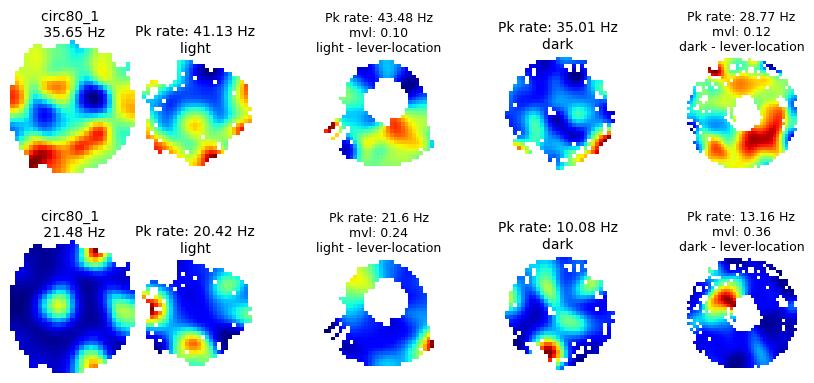

In [46]:
conditions = ['all_light', 'all_dark']
rs = ['arenaref', 'none']

cellIdToPlots= [session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[1].cluId, session_cells[session_cells.gridCell_FIRST].iloc[0].cluId]



nrows = len(cellIdToPlots)
ncols = 6
rowSize, colSize = 2,1.6

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig, width_ratios=[0.8,1,1,1,1,1], wspace=  0.2)

for i, cellIdToPlot in enumerate(cellIdToPlots):
    gsOpenfiled = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[i,:1])
    axes= fig.add_subplot(gsOpenfiled[0])
    plotmap(axes, cellIdToPlot, myMaps, condition= 'circ80_1', showYLabel=True)

    gscell = gridspec.GridSpecFromSubplotSpec(1,4,subplot_spec= gs[i,1:5], wspace=0.3)
    plot_multiple_lever_maps(gscell,cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs)

## Plot the lever center maps


In [47]:
fn=myProject.dataPath+"/results/myLeverMapsDissociate_180.pickle"
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMaps180 = pickle.load(handle)

    
fn=myProject.dataPath+"/results/myLeverMapsDissociateStats_180.pickle"
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMapsStats = pickle.load(handle)



loading /adata/projects/autopi_inter//results/myLeverMapsDissociate_180.pickle
loading /adata/projects/autopi_inter//results/myLeverMapsDissociateStats_180.pickle


In [48]:
def plotMap(ax,myMap,title="",titleY=0.95):
    """
    Plot one 2D map
    """
    ax.imshow(myMap.T,origin="lower",cmap='jet',interpolation=None)
    ax.set_title(title,y=titleY, fontsize= 9)
    ax.axis('off')
    
def plotLeverCenter(gs,cellIndex,light):
    
    gsPlan = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs[0], height_ratios=[0.1,1], width_ratios=[1,1,0.4,1,1,0.4,1,1]) # to get space for titles between rows
    #cellIndex = pyrId[pyrId==cellId].index.item()
    allCond="all_"+light
    
    #for i,(ref,refTitle) in  enumerate(zip(["none","bridge","lever"],["Cardinal","Bridge","Lever"])):
    #for i,(ref,refTitle) in  enumerate(zip(["none","lever"],["Cardinal","Lever"])):
    for i,(ref,refTitle) in  enumerate(zip(["lever"],["Lever"])):    
        
        # put the Cardinal,Bridge and Lever titles
       # ax = fig.add_subplot(gsLetter[i*2])
        #ax.text(0.5,1.3,light.capitalize(),fontsize=14,horizontalalignment='center')
        #ax.axis("off")
        
        
        ax = fig.add_subplot(gsPlan[1,i*3])
        rateType="map"
        plotMap(ax = ax, myMap = myLeverMaps180[rateType][allCond][ref][cellIndex],
               title="{:.1f} Hz\n {}".format(np.nanmax(myLeverMaps180[rateType][allCond][ref][cellIndex]), light),
               titleY=0.98)

        gsPolar = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1,i*3+1])
        ax = fig.add_subplot(gsPolar[0],polar=True)

        rateType="angular"
        ax.plot(np.append(np.arange(-np.pi,np.pi,2*np.pi/36),-np.pi),
                np.append(myLeverMaps180[rateType][allCond][ref][cellIndex],myLeverMaps180[rateType][allCond][ref][cellIndex][0]))
        ax.set_xticklabels([])
        ax.set_title("{:.2f} vl, {:.1f} Hz\n {}".format(myLeverMapsStats[rateType][allCond][ref][cellIndex,2],myLeverMapsStats[rateType][allCond][ref][cellIndex,4], light),y=0.98, fontsize= 10)
        ax.grid(True)

In [49]:
def plotLeverCenterExamples(gs, fsInd, myLeverMaps180, myLeverMapsStats):
    
    '''
    fsInd: is the index of the cell from the cells df
    '''
    
    conditions = ['light', 'dark']
    for i, light in enumerate(conditions):
        allCond = f"all_{light}"
        ref = 'lever'
        cellIndex = fsInd
        rateType = "map"
        myMap = myLeverMaps180[rateType][allCond][ref][cellIndex]
        title = "{}-leverRotation \n Peakrate:{:.1f} Hz\n mvl:{:.2f}".format(light,
            np.nanmax(myLeverMaps180[rateType][allCond][ref][cellIndex]),
            myLeverMapsStats['angular'][allCond][ref][cellIndex, 2][0]
        )
        ax = fig.add_subplot(gs[i])
        plotMap(ax=ax, myMap=myMap, title=title, titleY=0.98)

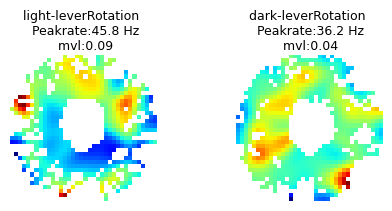

In [50]:
col, row = 2, 1
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.3)

celltoplot= session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[1].cluId
fsInd= cells[cells.cluId== celltoplot].index.values.astype(int)
plotLeverCenterExamples(gs, fsInd, myLeverMaps180, myLeverMapsStats)

In [51]:
def plot_allmaps_onecell(gs, cellIdToPlots):
    
    conditions = ['all_light', 'all_dark']
    rs = ['arenaref', 'none']

    for i, cellIdToPlot in enumerate(cellIdToPlots):
        gsOpenfiled = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[i,:1])
        axes= fig.add_subplot(gsOpenfiled[0])
        plotmap(axes, cellIdToPlot, myMaps, condition= 'circ80_1', showYLabel=True)

        gscell = gridspec.GridSpecFromSubplotSpec(1,4,subplot_spec= gs[i,1:5], wspace=0.3)
        plot_multiple_lever_maps(gscell,cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs)
        
        gslever = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[i,5:], wspace=0.0)
        #plot_atLeverMaps_withRotations_all(gslever, cellIdToPlot)
        cind=  cells[cells.cluId==cellIdToPlot].index.values.astype(int)
        plotLeverCenterExamples(gslever, cind, myLeverMaps180, myLeverMapsStats)

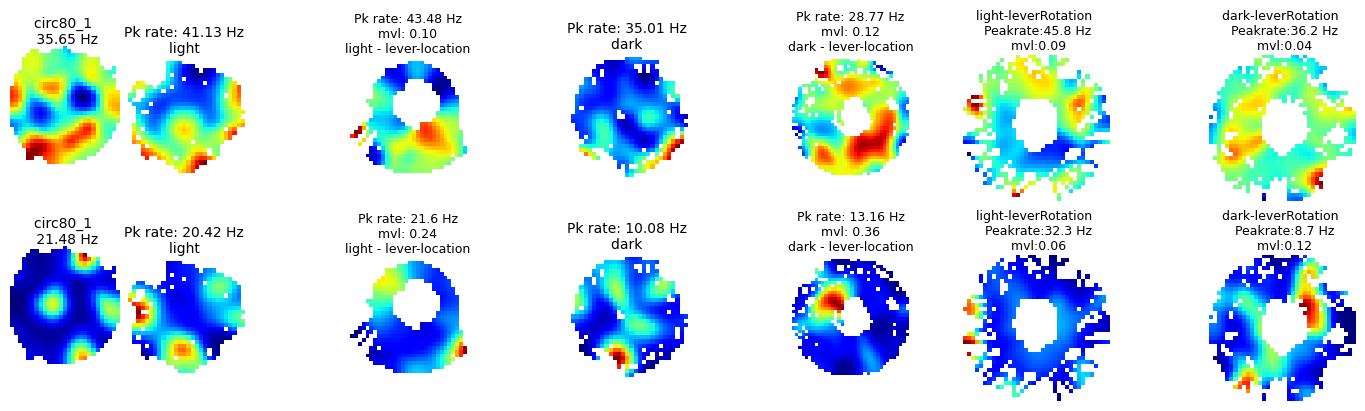

In [52]:
cellIdToPlots= [session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[1].cluId]
cellIdToPlots= [session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[1].cluId, session_cells[session_cells.gridCell_FIRST].iloc[0].cluId]

nrows = len(cellIdToPlots)
ncols = 7
rowSize, colSize = 2,2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,  width_ratios=[0.6,1,1,1,1,1.5,1], wspace=  0.0)


plot_allmaps_onecell(gs, cellIdToPlots)



## Find a session with more FS

In [53]:
cells[(cells.interneuron) & (cells.mrate_RF1> 10)].groupby('session').size().reset_index(name='count').sort_values(by='count', ascending=False).iloc[:1]

,session,count
82,jp486-09032023-0108,14


In [58]:
def get_session_results_for_one_session(sSes, stack, cells):
    # Initialize a dictionary to store data for the session and light conditions
    session_results = {}
    
    # Unpack the stack data
    stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]
    
    # Get cells corresponding to the session
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values
    stacked_ifr_fsl = stackedifr_cells[trials_light_ids][:, fsin_indx]  # use raw
    stacked_ifr_fsd = stackedifr_cells[trials_dark_ids][:, fsin_indx] 
    
    # Loop through light conditions
    for light, stacked_ifr in zip(['light', 'dark'], [stacked_ifr_fsl, stacked_ifr_fsd]):
        
        arrs = []
        peakInds = []
        BaselineMeans = []
        BaselineToPeakdiffs = []
        FSInds = []

        # Loop through FS cells
        for cind in range(sum(fsin_indx)):
            
            arr, peak_index, baseline_mean, peak_to_baseline_diff = get_peak_to_baseline(stacked_ifr, cind, time_scaled)
            arrs.append(arr)
            peakInds.append(peak_index)
            BaselineMeans.append(baseline_mean)
            BaselineToPeakdiffs.append(peak_to_baseline_diff)
            FSInds.append(cind)
        
        # Find the FS index with the highest peak-to-baseline difference
        if len(BaselineToPeakdiffs) != 0:
            fsIndwithPeak = np.argmax(BaselineToPeakdiffs)
            fscluidwithPeak = session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[fsIndwithPeak].cluId
        else:
            fsIndwithPeak = np.nan
            fscluidwithPeak = np.nan

        # Store the results for this light condition in the session_results dictionary
        session_results[light] = {
            'session': sSes.name,
            'numfs': sum(fsin_indx),
            'arrs': arrs,
            'time_scaled': time_scaled,
            'fsind': FSInds,
            'peakInds': peakInds,
            'BaselineMeans': BaselineMeans,
            'BaselineToPeakdiffs': BaselineToPeakdiffs,
            'fsIndwithPeak': fsIndwithPeak,
            'fscluidwithPeak': fscluidwithPeak, 
            'FScluids':(session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].cluId)
        }
    
    return session_results


In [157]:
sesName= 'jp486-09032023-0108'
sSesind= [sSes.name for sSes in sSessions].index(sesName)
print(sSesind)
sSes= sSessions[sSesind]
ses= myProject.sessionList[sSesind]


152


In [158]:
stack = get_stacked_ifr_all_sessions[sSesind]
session_results= get_session_results_for_one_session(sSes, stack, cells)

In [159]:
session_results.keys(), session_results['light'].keys(), len(session_results['light']['arrs']), session_results['light']['numfs'], session_results['light']['fscluidwithPeak'], session_results['light']['fsIndwithPeak']

(dict_keys(['light', 'dark']),
 dict_keys(['session', 'numfs', 'arrs', 'time_scaled', 'fsind', 'peakInds', 'BaselineMeans', 'BaselineToPeakdiffs', 'fsIndwithPeak', 'fscluidwithPeak', 'FScluids']),
 14,
 14,
 'jp486-09032023-0108_1338',
 11)

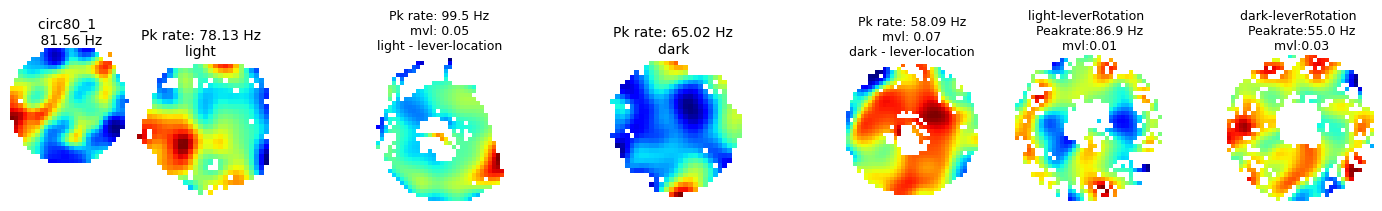

In [68]:
cellIdToPlots= ['jp486-09032023-0108_1338']
nrows = len(cellIdToPlots)
ncols = 7
rowSize, colSize = 2,2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,  width_ratios=[0.6,1,1,1,1,1,1], wspace=  0.0)


plot_allmaps_onecell(gs, cellIdToPlots)


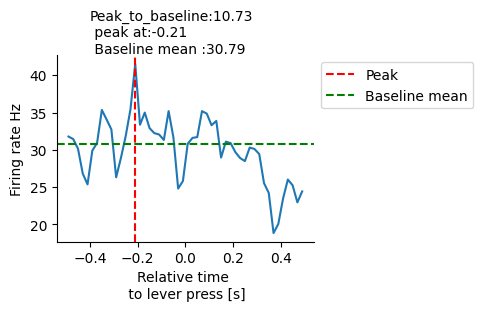

In [69]:
# Plot settings
col = 5
row = 1
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ax= fig.add_subplot(gs[0])

stack = get_stacked_ifr_all_sessions[sSesind]
session_results= get_session_results_for_one_session(sSes, stack, cells)

cind= session_results['light']['fsIndwithPeak']
arr= session_results['light']['arrs'][cind]
peak_index= session_results['light']['peakInds'][cind]
baseline_mean= session_results['light']['BaselineMeans'][cind]
peak_to_baseline_diff= session_results['light']['BaselineToPeakdiffs'][cind]

plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_baseline_diff,text_pos= [-0.4, 43], legend= True)

## plot all the fs cellsin this session 

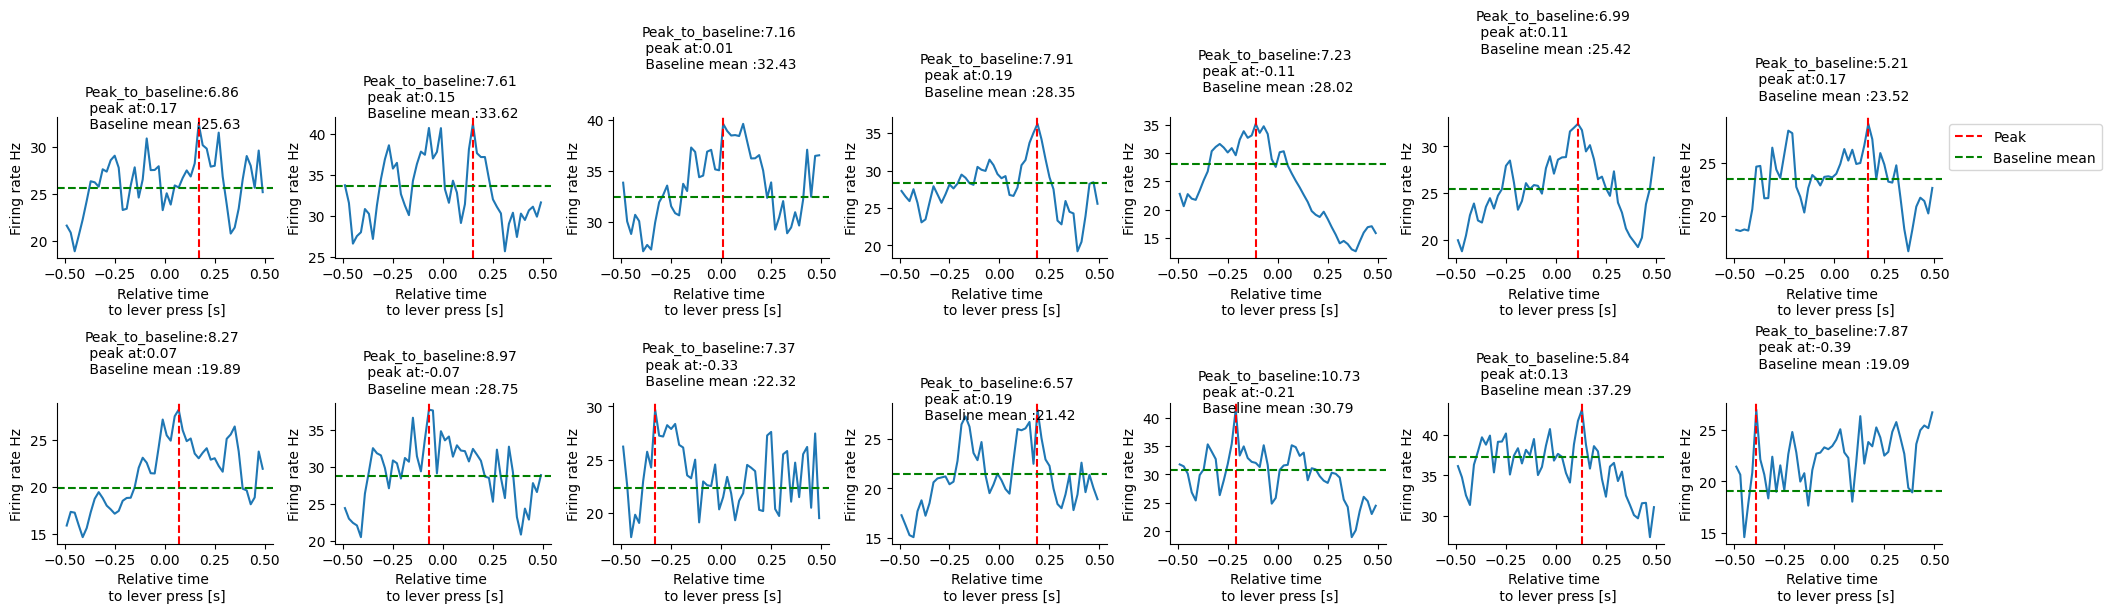

In [70]:
# Plot settings
col = 7
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


cinds=((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values
session_cells = cells[(cells.session == sSes.name)]

text_positions = [[-0.4, 32], [-0.4, 42], [-0.4, 45], [-0.4, 40], [-0.4, 41], [-0.4, 40], [-0.4, 31],
                 [-0.4, 32], [-0.4, 40], [-0.4, 32], [-0.4, 27], [-0.4, 41], [-0.4, 45], [-0.4, 31]]  # Example positions for text
for i, cind in  enumerate(range(sum(cinds))):
    # Create subplot
    ax = fig.add_subplot(gs[i])
    
    arr= session_results['light']['arrs'][cind]
    peak_index= session_results['light']['peakInds'][cind]
    baseline_mean= session_results['light']['BaselineMeans'][cind]
    peak_to_baseline_diff= session_results['light']['BaselineToPeakdiffs'][cind]
   
    # Plot the data
    plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_baseline_diff,
                              text_pos=text_positions[i], legend=(i == 6))  # Legend only for the third plot


## Run this for all the cells in one session 

In [71]:
df.keys(), len(get_stacked_ifr_all_sessions), len(get_stacked_ifr_all_sessions[0])

(Index(['Info_score', 'HD_score', 'HD_peakrate', 'cluid', 'light', 'shuffle'], dtype='object'),
 180,
 4)

In [73]:
# Initialize a list to store data for each session and light condition
session_results = []

for sSes, stack in zip(sSessions, get_stacked_ifr_all_sessions[:]):
    
    sSesNames.append(sSes.name)
    stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]
    
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values
    stacked_ifr_fsl = stackedifr_cells[trials_light_ids][:, fsin_indx]  # use raw
    stacked_ifr_fsd = stackedifr_cells[trials_dark_ids][:, fsin_indx] 
    
    # Loop through light conditions
    for light, stacked_ifr in zip(['light', 'dark'], [stacked_ifr_fsl, stacked_ifr_fsd]):
        
        arrs = []
        peakInds = []
        BaselineMeans = []
        BaselineToPeakdiffs = []
        FSInds = []

        # Loop through FS cells
        for cind in range(sum(fsin_indx)):
            
            arr, peak_index, baseline_mean, peak_to_baseline_diff = get_peak_to_baseline(stacked_ifr, cind, time_scaled)
            arrs.append(arr)
            peakInds.append(peak_index)
            BaselineMeans.append(baseline_mean)
            BaselineToPeakdiffs.append(peak_to_baseline_diff)
            FSInds.append(cind)
        
        # Find the FS index with the highest peak-to-baseline difference
        if len(BaselineToPeakdiffs) !=0:
            fsIndwithPeak = np.argmax(BaselineToPeakdiffs)
            fscluidwithPeak= session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[fsIndwithPeak].cluId
            #print(fsIndwithPeak)
        else:
            fsIndwithPeak = np.nan
            fscluidwithPeak= np.nan

        # Append the results for this light condition to the session_results list
        session_results.append({
            'session': sSes.name,
            'numfs':sum(fsin_indx),
            'fsids':list(session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].cluId),
            'light': light,
            'arrs': arrs,
            'time_scaled':time_scaled,
            'fsind': FSInds,
            'peakInds': peakInds,
            'BaselineMeans': BaselineMeans,
            'BaselineToPeakdiffs': BaselineToPeakdiffs,
            'fsIndwithPeak': fsIndwithPeak,
            'fscluidwithPeak':fscluidwithPeak
        })

# Convert the session_results list into a DataFrame
sesdf = pd.DataFrame(session_results)

/home/maryam/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/maryam/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [74]:
sesdf

,session,numfs,fsids,light,arrs,time_scaled,fsind,peakInds,BaselineMeans,BaselineToPeakdiffs,fsIndwithPeak,fscluidwithPeak
0,mn8578-30112021-0107,0,[],light,[],"[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",[],[],[],[],NaN,NaN
1,mn8578-30112021-0107,0,[],dark,[],"[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",[],[],[],[],NaN,NaN
2,mn8578-05122021-0108,1,[mn8578-05122021-0108_241],light,"[[18.57752804898403, 18.316683031142585, 16.99...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",[0],[45],[19.093375450748958],[8.834411956071726],0.0,mn8578-05122021-0108_241
3,mn8578-05122021-0108,1,[mn8578-05122021-0108_241],dark,"[[20.71200641211019, 21.735616269236843, 23.31...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",[0],[43],[21.694752753674074],[7.78775125740453],0.0,mn8578-05122021-0108_241
4,mn8578-06122021-0107,1,[mn8578-06122021-0107_21],light,"[[23.16802564994531, 21.592509240248894, 19.65...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",[0],[43],[22.365641938479033],[6.945719585082667],0.0,mn8578-06122021-0107_21
...,...,...,...,...,...,...,...,...,...,...,...,...
355,jp499-16052023-0108,0,[],dark,[],"[-0.49, -0.47000000000000003, -0.45, -0.43, -0...",[],[],[],[],NaN,NaN
356,jp499-18052023-0108,4,"[jp499-18052023-0108_497, jp499-18052023-0108_...",light,"[[25.349707281453757, 27.432854743332914, 27.0...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...","[0, 1, 2, 3]","[24, 33, 22, 17]","[25.0430970826078, 17.834433078159552, 9.05133...","[5.460792071223867, 4.999834782614638, 3.04754...",3.0,jp499-18052023-0108_741
357,jp499-18052023-0108,4,"[jp499-18052023-0108_497, jp499-18052023-0108_...",dark,"[[37.74073779610754, 34.77667141274402, 31.930...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...","[0, 1, 2, 3]","[0, 2, 20, 9]","[nan, 20.221543591992372, 6.283564594849556, 3...","[nan, 5.441326717339589, 1.953213129286624, 8....",0.0,jp499-18052023-0108_497
358,jp499-25052023-0108,5,"[jp499-25052023-0108_298, jp499-25052023-0108_...",light,"[[12.485370622670048, 11.255676823798893, 11.4...","[-0.49, -0.47000000000000003, -0.45, -0.43, -0...","[0, 1, 2, 3, 4]","[36, 44, 28, 36, 12]","[12.404983608710412, 34.40706761366278, 32.624...","[3.998323332191548, 8.456576120415875, 5.71255...",1.0,jp499-25052023-0108_330


In [75]:
sesdf[(~sesdf.fscluidwithPeak.isna()) & (sesdf.light=='light')].fscluidwithPeak.shape

(153,)

## Plot the 2d map of 10 of these cells 

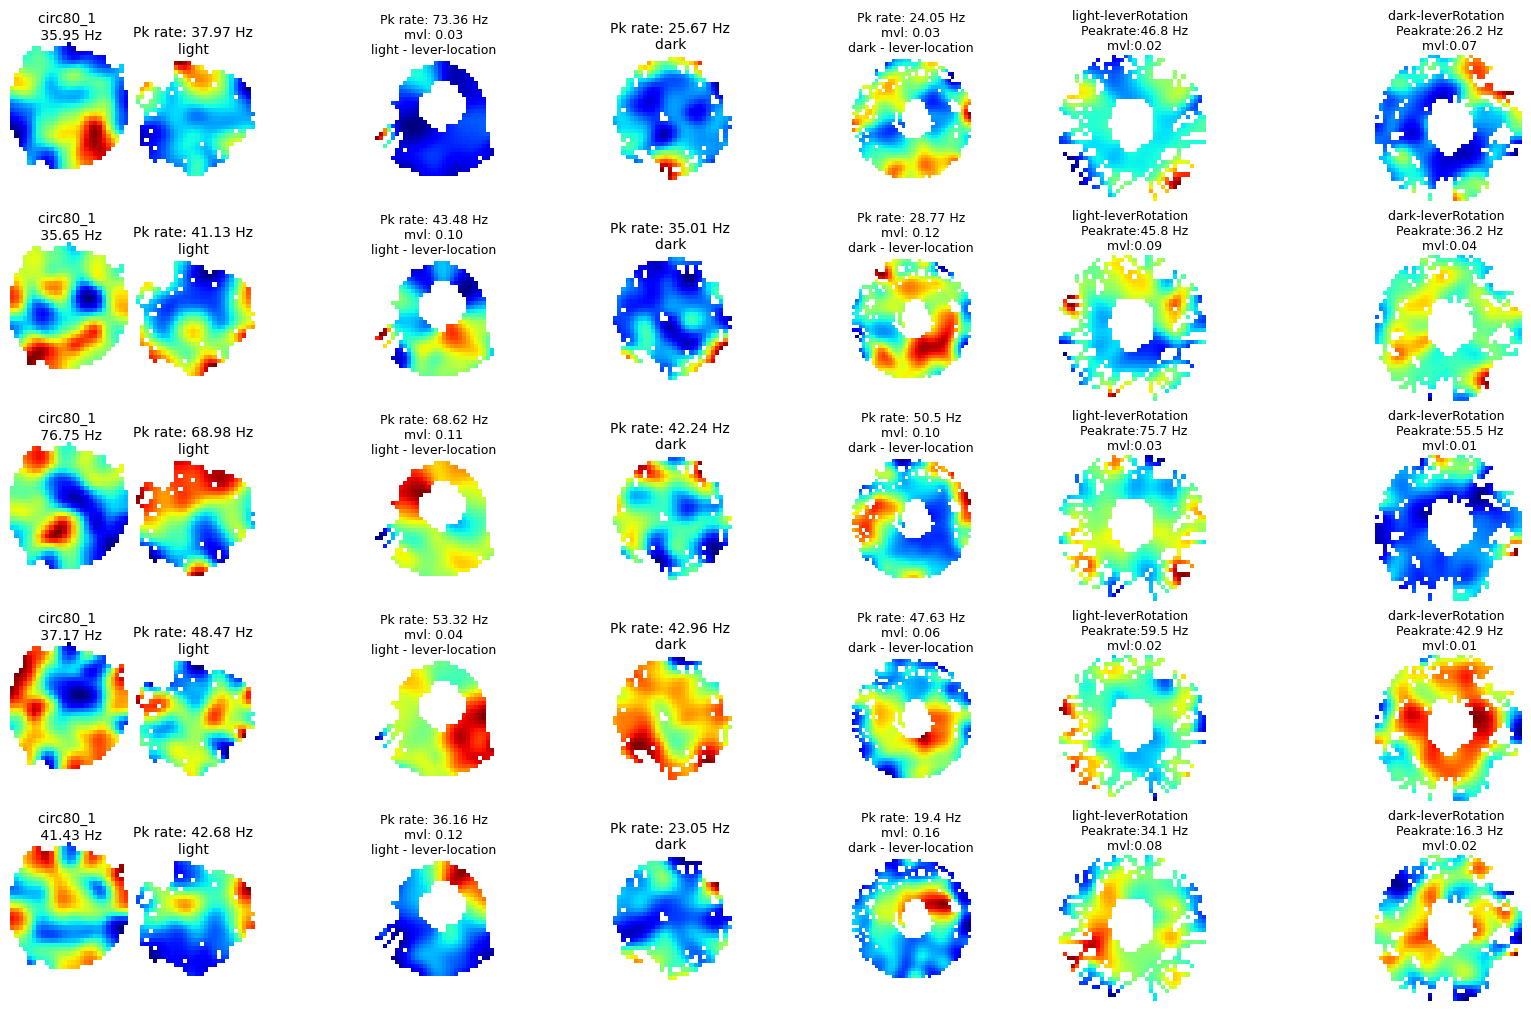

In [115]:
ses= myProject.sessionList[10]
sSes= sSessions[10]
cellIdToPlots= list(cells[(cells.session== sSes.name) & (cells.interneuron) & (cells.mrate_RF1> 10)].cluId)

nrows = len(cellIdToPlots)
ncols = 8
rowSize, colSize = 2,2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,  width_ratios=[0.6,1,1,1,1,1,1,1], wspace=  0.0)


plot_allmaps_onecell(gs, cellIdToPlots)


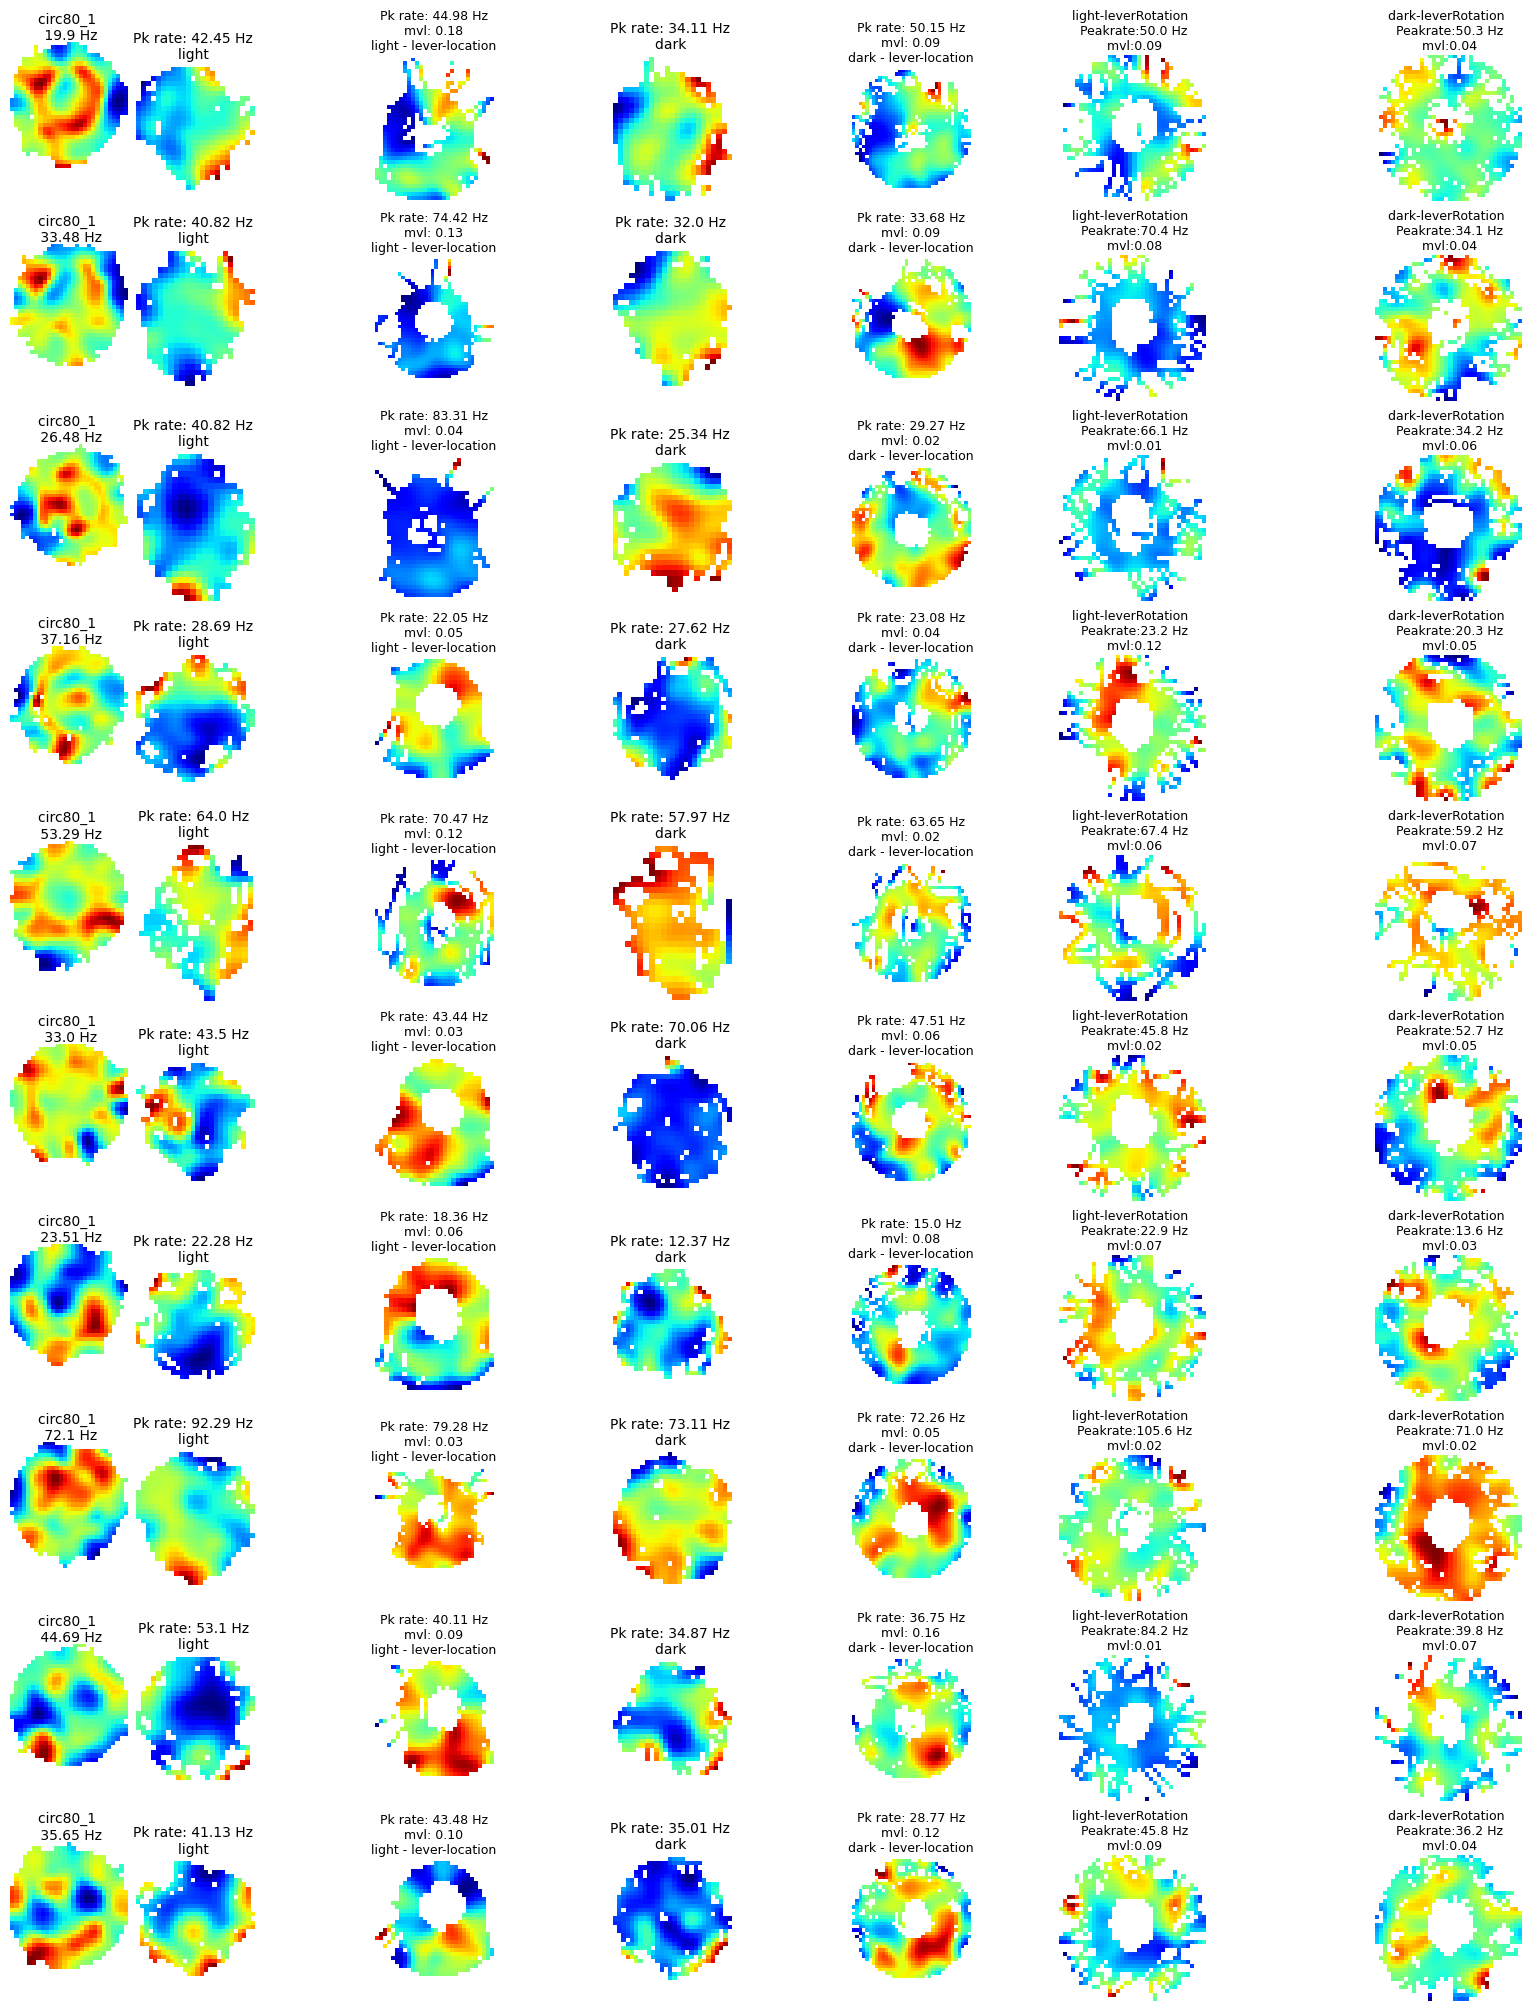

In [79]:
cellIdToPlots= list(sesdf[(~sesdf.fscluidwithPeak.isna()) & (sesdf.light=='light')].fscluidwithPeak)[:10]

nrows = len(cellIdToPlots)
ncols = 8
rowSize, colSize = 2,2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,  width_ratios=[0.6,1,1,1,1,1,1,1], wspace=  0.0)


plot_allmaps_onecell(gs, cellIdToPlots)



## Compare the mvl in the lever reference frame and the lever centered map for these cells 

In [82]:
myLeverMapsStats.keys(), df_HDInfo.keys()

(dict_keys(['angular']),
 Index(['Info_score', 'HD_score', 'HD_peakrate', 'cluid', 'Info_pc', 'HD_pc',
        'peak_pc', 'light', 'shuffle', 'sessionName', 'mouse'],
       dtype='object'))

/home/maryam/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


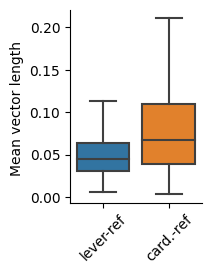

In [84]:
# Define the colors for the plots
hue_colors_hist = {'fs': 'red', 'gc': 'blue'}  # Red for fs, blue for gc
hue_colors_box = {'dark': '#004c99', 'light': '#ffaa00'}  # Dark blue for light, dark yellow for dark in boxplot
hue_colors_box = {'dark': '#004c99', 'light': '#ffaa00'}  # Dark blue for light, dark yellow for dark in boxplot


fswithpeakids= list(sesdf[(~sesdf.fscluidwithPeak.isna()) & (sesdf.light=='light')].fscluidwithPeak)
fswithpeakindexs= cells[cells.cluId.isin(fswithpeakids)].index.values.astype(int)

allCond= 'all_'+ 'light'
ref= 'lever'
levermvl= list(myLeverMapsStats['angular'][allCond][ref][fswithpeakindexs, 2])
cardmvl= list(df_HDInfo[df_HDInfo.cluid.isin(fswithpeakids) & (df_HDInfo.light== 'all_light') & (~df_HDInfo.shuffle)].HD_score)
len(levermvl), len(cardmvl)

mvldf= pd.DataFrame({'levermvl': levermvl, 
                     'cardmvl': cardmvl})

ncols = 1
rowSize, colSize = 2,2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

ax= fig.add_subplot(gs[0])
sns.boxplot(data= mvldf, ax= ax, dodge=True, showfliers=False) #, palette=hue_colors_box)
ax.set_ylabel('Mean vector length ')
xlabs= ['lever-ref', 'card.-ref']
ax.set_xticklabels(xlabs, rotation= 45)
#ax.set_xlabel('Relative time \n to lever press [s]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [371]:
sesdf.keys()

Index(['session', 'numfs', 'fsids', 'light', 'arrs', 'time_scaled', 'fsind',
       'peakInds', 'BaselineMeans', 'BaselineToPeakdiffs', 'fsIndwithPeak',
       'fscluidwithPeak'],
      dtype='object')

In [378]:
sesdf[(~sesdf.fscluidwithPeak.isna()) & (sesdf.light=='light')].fsids.shape


(153,)

In [375]:
fsids= list(sesdf[(~sesdf.fscluidwithPeak.isna()) & (sesdf.light=='light')].fsids)

seslist= list(sesdf[(~sesdf.fscluidwithPeak.isna())].session)
  

## Get the cross correlation between all fs and all gc for all sessions 

In [82]:
def pcorr(a,b):
    r,p=pearsonr(a.flatten(),b.flatten())
    return r

def normalize_zscore(x):
    return (x-np.mean(x))/np.std(x)

def corr_norm(x,y,mode="full"):
    x_=normalize_zscore(x)
    y_=normalize_zscore(y)
    return np.correlate(x_,y_,mode=mode)/len(x)
    
def corr_norm_2d(A,B):
    C = np.nanmean([corr_norm(a,b) for a,b in zip(A,B)], axis=0)
    shifts = np.arange(len(C))-len(C)//2
    return C, shifts
    

In [77]:
t_lists= []
v_lists= []
corrs=[]
for sSes, stack in zip(sSessions, get_stacked_ifr_all_sessions[:]):
    
    sSesNames.append(sSes.name)
    stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]
    
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values
    neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))
    # Normalize the data
    stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)
    
    fsin_indx_ = np.where(fsin_indx)[0]
    gc_indx_ = np.where(gc_indx)[0]
    fs_gc_pairs = list(product(fsin_indx_, gc_indx_))
    t_list=[]
    v_list=[]
    corr_list=[]
    light_condition= trials_light_ids
    for fsindx,gcindx in tqdm(fs_gc_pairs):

        x = stackedifr_cells_normalized[light_condition][:, fsindx]
        y = stackedifr_cells_normalized[light_condition][:, gcindx]

        x_ = x.copy()
        y_ = y.copy()
        x_[np.isnan(x_)]=0
        y_[np.isnan(y_)]=0

        corr, corr_times = corr_norm_2d(x_,y_)
        corr_list.append(corr)
        corr_times=corr_times*bin_size_sec
        #t = corr_times[np.nanargmax(corr)]
        t = corr_times[np.argmax(corr)]
        #v = np.nanmax(corr)
        v = np.max(corr)
        t_list.append(t)
        v_list.append(v)
        
    t_list=np.array(t_list)
    v_list=np.array(v_list)

    # Append results to the cumulative lists
    t_lists.append(t_list)
    v_lists.append(v_list)
    corrs.append(corr_list)

/tmp/ipykernel_853601/265617880.py:14: RuntimeWarning: invalid value encountered in divide
  stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)
0it [00:00, ?it/s]
  0%|                                                                            | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_853601/29706544.py:6: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)
100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 367.00it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 327.95it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 403.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 424.75it/s]
0it [00:00, ?it/s]
100%|███

In [78]:
len(t_lists), len(v_lists), t_lists[2].shape, t_lists[2]

(180, 180, (6,), array([ 0.  , -0.08,  0.6 , -0.06, -0.06,  0.  ]))

In [79]:
ts= np.concatenate(t_lists)
vs= np.concatenate(v_lists)
#crs= np.concatenate(corrs)

Text(0.5, 1.0, 'All FS against all GCs')

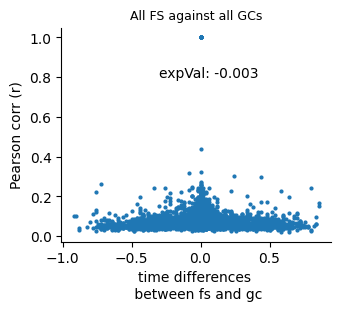

In [94]:

nrows= 1
ncols = 2
rowSize, colSize = 3,3
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

ax= fig.add_subplot(gs[1])
ax.scatter(ts,vs, s= 4)
ax.set_xlabel('time differences \n between fs and gc')
ax.set_ylabel('Pearson corr (r)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.3, 0.8, f'expVal: {expected_value(ts, vs):.3f}')
ax.set_title('All FS against all GCs', fontsize= 9)

# Find the pairs of FS and GC on the same shank and plot the same thing :

In [674]:
sesName= 'jp486-09032023-0108'
sSesind= [sSes.name for sSes in sSessions].index(sesName)
sSes= sSessions[sSesind]
ses= myProject.sessionList[sSesind]
session_cells = cells[(cells.session == sSes.name)]

stack= get_stacked_ifr_all_sessions[sSesind]
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]
stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)

In [675]:
session_cells[session_cells.gridCell_FIRST].shape, session_cells[(session_cells.interneuron ) & (session_cells.mrate_RF1> 10)].shape

((20, 41), (14, 41))

In [676]:
# Function to compute correlations and extract max correlation and corresponding time
def getCorr_pairs(stackedifr_cells_normalized, pairs, condition_ids):
    t_list = []
    v_list = []
    corr_list = []

    for fsindx, gcindx in tqdm(pairs):
        x = stackedifr_cells_normalized[condition_ids][:, fsindx]
        y = stackedifr_cells_normalized[condition_ids][:, gcindx]

        # Replace NaNs with 0 in x and y
        x_ = np.nan_to_num(x)
        y_ = np.nan_to_num(y)

        corr, corr_times = corr_norm_2d(x_, y)
        corr_list.append(corr)

        corr_times = corr_times.astype(float) * bin_size_sec

        t_list.append(corr_times[np.argmax(corr)])
        v_list.append(np.max(corr))
    
    return np.array(t_list), np.array(v_list), corr_list


## try to find a way to save the data from all the shanks and hemishphers 

In [677]:
# Initialize the list to store all results
data = []

# Iterate over each hemisphere
for h in hems:
    # Iterate over each shank
    for sh in shanks:
        sameshank_cells = session_cells[(session_cells.shank == sh) & (session_cells.cell_hemishphere == h)]
        othershank_cells = session_cells[~session_cells.cluId.isin(sameshank_cells.cluId)]

        # Get the fs and grid cell indices
        fsin_indx = np.where((sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1 > 10))[0]
        gc_ssh_indx = np.where(sameshank_cells.gridCell_FIRST.values)[0]
        gc_othsh_indx = np.where(othershank_cells.gridCell_FIRST.values)[0]

        # Generate pairs
        pairs_sshank = list(product(fsin_indx, gc_ssh_indx))
        pairs_Othshank = list(product(fsin_indx, gc_othsh_indx))

        # Initialize the results dictionary for this specific shank and hemisphere
        results = {
            "same": {"light": {"t_list": [], "v_list": [], "corr_list": []},
                     "dark": {"t_list": [], "v_list": [], "corr_list": []}},
            "other": {"light": {"t_list": [], "v_list": [], "corr_list": []},
                      "dark": {"t_list": [], "v_list": [], "corr_list": []}}
        }

        # Iterate over both light and dark conditions
        for condition_name, condition_ids in [("light", trials_light_ids), ("dark", trials_dark_ids)]:
            # Process same-shank pairs
            t_list_sshank, v_list_sshank, corr_list_sshank = getCorr_pairs(stackedifr_cells_normalized, pairs_sshank, condition_ids)
            results["same"][condition_name]["t_list"].extend(t_list_sshank)
            results["same"][condition_name]["v_list"].extend(v_list_sshank)
            results["same"][condition_name]["corr_list"].extend(corr_list_sshank)

            # Process other-shank pairs
            t_list_Othshank, v_list_Othshank, corr_list_Othshank = getCorr_pairs(stackedifr_cells_normalized, pairs_Othshank, condition_ids)
            results["other"][condition_name]["t_list"].extend(t_list_Othshank)
            results["other"][condition_name]["v_list"].extend(v_list_Othshank)
            results["other"][condition_name]["corr_list"].extend(corr_list_Othshank)

        # Append the results to the data list after processing each shank and hemisphere
        for shank_type in ["same", "other"]:
            for condition_name in ["light", "dark"]:
                data.append({
                    "shank_type": shank_type,
                    "condition": condition_name,
                    "t_list": results[shank_type][condition_name]["t_list"],
                    "v_list": results[shank_type][condition_name]["v_list"],
                    "corr_list": results[shank_type][condition_name]["corr_list"],
                    "fs_ids": sameshank_cells[(sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1 > 10)].cluId.tolist(),
                    "gc_sshank_ids": sameshank_cells[sameshank_cells.gridCell_FIRST].cluId.tolist(),
                    "gc_othshank_ids": othershank_cells[othershank_cells.gridCell_FIRST].cluId.tolist(),
                    "num_fs": len(sameshank_cells[(sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1 > 10)].cluId.tolist()),
                    "num_gc_sshank": len(sameshank_cells[sameshank_cells.gridCell_FIRST].cluId.tolist()),
                    "num_gc_Othshank": len(othershank_cells[othershank_cells.gridCell_FIRST].cluId.tolist()),
                    "hemisphere": h,  # Include the hemisphere
                    "shank": sh,       # Include the shank
                })

# Convert the accumulated data to a DataFrame
sesdf = pd.DataFrame(data)
sesdf['session'] = sSes.name



  0%|                                                                           | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_853601/29706544.py:6: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)
  0%|                                                                           | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_853601/29706544.py:14: RuntimeWarning: Mean of empty slice
  C = np.nanmean([corr_norm(a,b) for a,b in zip(A,B)], axis=0)
100%|█████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 209.50it/s]


In [679]:
sesdf

,shank_type,condition,t_list,v_list,corr_list,fs_ids,gc_sshank_ids,gc_othshank_ids,num_fs,num_gc_sshank,num_gc_Othshank,hemisphere,shank,session
0,same,light,"[0.18, -0.06, -0.48, 0.6, 0.02, 0.34, 0.3, -0....","[0.08359349638889668, 0.06802758278538794, 0.0...","[[-0.002036554174585212, -0.001851236977459903...","[jp486-09032023-0108_945, jp486-09032023-0108_...","[jp486-09032023-0108_1060, jp486-09032023-0108...","[jp486-09032023-0108_421, jp486-09032023-0108_...",5,3,17,right,1,jp486-09032023-0108
1,same,dark,"[0.26, 0.3, -0.02, 0.16, -0.34, 0.0, -0.6, 0.2...","[0.05957692078072057, 0.04385921231344786, 0.1...","[[0.00854764317466045, 0.005138413017339567, -...","[jp486-09032023-0108_945, jp486-09032023-0108_...","[jp486-09032023-0108_1060, jp486-09032023-0108...","[jp486-09032023-0108_421, jp486-09032023-0108_...",5,3,17,right,1,jp486-09032023-0108
2,other,light,"[-0.04, 0.38, 0.12, -0.4, 0.0, -0.04, -0.16, -...","[0.050701312172380816, 0.08019473446766745, 0....","[[-0.009834982206055267, -0.015508342260135262...","[jp486-09032023-0108_945, jp486-09032023-0108_...","[jp486-09032023-0108_1060, jp486-09032023-0108...","[jp486-09032023-0108_421, jp486-09032023-0108_...",5,3,17,right,1,jp486-09032023-0108
3,other,dark,"[0.18, -0.06, -0.34, 0.0, 0.0, -0.4, -0.54, 0....","[0.0564863926383266, 0.1052604150075153, 0.105...","[[0.021965750417444432, 0.02023810486835388, 0...","[jp486-09032023-0108_945, jp486-09032023-0108_...","[jp486-09032023-0108_1060, jp486-09032023-0108...","[jp486-09032023-0108_421, jp486-09032023-0108_...",5,3,17,right,1,jp486-09032023-0108
4,same,light,"[0.22, 0.06, 0.18, 0.5, -0.98, -0.98, 0.26, -0...","[0.2543896311927559, 0.5667697276159565, 0.368...","[[0.00038323102922021646, 0.001307781747004686...","[jp486-09032023-0108_1228, jp486-09032023-0108...","[jp486-09032023-0108_1276, jp486-09032023-0108...","[jp486-09032023-0108_421, jp486-09032023-0108_...",6,9,11,right,0,jp486-09032023-0108
5,same,dark,"[-0.98, -0.98, -0.98, -0.98, -0.98, -0.98, -0....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[jp486-09032023-0108_1228, jp486-09032023-0108...","[jp486-09032023-0108_1276, jp486-09032023-0108...","[jp486-09032023-0108_421, jp486-09032023-0108_...",6,9,11,right,0,jp486-09032023-0108
6,other,light,"[-0.98, 0.16, 0.0, 0.76, -0.98, 0.72, -0.98, 0...","[nan, 0.6550875484535555, 0.846843794523594, 0...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[jp486-09032023-0108_1228, jp486-09032023-0108...","[jp486-09032023-0108_1276, jp486-09032023-0108...","[jp486-09032023-0108_421, jp486-09032023-0108_...",6,9,11,right,0,jp486-09032023-0108
7,other,dark,"[-0.98, -0.98, -0.98, -0.98, -0.98, -0.98, -0....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[jp486-09032023-0108_1228, jp486-09032023-0108...","[jp486-09032023-0108_1276, jp486-09032023-0108...","[jp486-09032023-0108_421, jp486-09032023-0108_...",6,9,11,right,0,jp486-09032023-0108
8,same,light,[0.22],[0.08430026792144947],"[[-0.00730191043162218, -0.009265410875220892,...",[jp486-09032023-0108_595],[jp486-09032023-0108_713],"[jp486-09032023-0108_421, jp486-09032023-0108_...",1,1,19,left,1,jp486-09032023-0108
9,same,dark,[0.02],[0.24375429778874438],"[[0.0022046601515587918, 0.005186569899506453,...",[jp486-09032023-0108_595],[jp486-09032023-0108_713],"[jp486-09032023-0108_421, jp486-09032023-0108_...",1,1,19,left,1,jp486-09032023-0108


## Grouping by adding the points in t_list and v_list together 

In [680]:
# Define aggregation functions to concatenate lists within each group
agg_functions = {
    't_list': lambda x: sum(x, []),
    'v_list': lambda x: sum(x, []),
    'corr_list': lambda x: sum(x, []),
}

# Group the DataFrame by 'shank_type' and 'condition', then aggregate using the defined functions
dfgrp = sesdf.groupby(['shank_type', 'condition'], as_index=False).agg(agg_functions)
dfgrp

,shank_type,condition,t_list,v_list,corr_list
0,other,dark,"[0.18, -0.06, -0.34, 0.0, 0.0, -0.4, -0.54, 0....","[0.0564863926383266, 0.1052604150075153, 0.105...","[[0.021965750417444432, 0.02023810486835388, 0..."
1,other,light,"[-0.04, 0.38, 0.12, -0.4, 0.0, -0.04, -0.16, -...","[0.050701312172380816, 0.08019473446766745, 0....","[[-0.009834982206055267, -0.015508342260135262..."
2,same,dark,"[0.26, 0.3, -0.02, 0.16, -0.34, 0.0, -0.6, 0.2...","[0.05957692078072057, 0.04385921231344786, 0.1...","[[0.00854764317466045, 0.005138413017339567, -..."
3,same,light,"[0.18, -0.06, -0.48, 0.6, 0.02, 0.34, 0.3, -0....","[0.08359349638889668, 0.06802758278538794, 0.0...","[[-0.002036554174585212, -0.001851236977459903..."


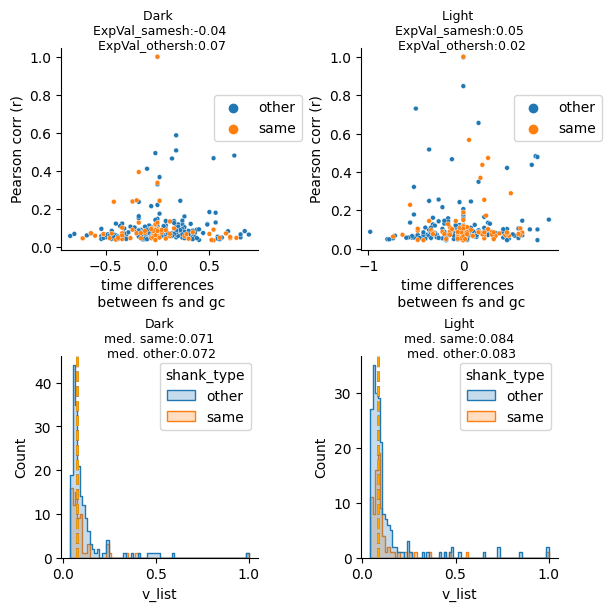

In [681]:
nrows= 2
ncols = 2
rowSize, colSize = 3,3
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

bbox_to_anchor= (1,0.8)

ax= fig.add_subplot(gs[0,0])
df_exploded = dfgrp.explode(['t_list', 'v_list'])
sns.scatterplot(data=df_exploded[df_exploded['condition'] == 'dark'], 
                x="t_list", y="v_list", hue='shank_type', s= 12)
ax.set_xlabel('time differences \n between fs and gc')
ax.set_ylabel('Pearson corr (r)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper center', bbox_to_anchor= bbox_to_anchor)

same_vald= expected_value(pd.to_numeric(df_exploded[(df_exploded.condition=='dark') & (df_exploded.shank_type== 'same')].t_list), pd.to_numeric(df_exploded[(df_exploded.condition=='dark') & ((df_exploded.shank_type== 'same'))].v_list))
other_vald= expected_value(pd.to_numeric(df_exploded[(df_exploded.condition=='dark') & (df_exploded.shank_type== 'other')].t_list), pd.to_numeric(df_exploded[(df_exploded.condition=='dark') & ((df_exploded.shank_type== 'other'))].v_list))
ax.set_title(f'Dark \n ExpVal_samesh:{same_vald:.2f} \n ExpVal_othersh:{other_vald:.2f}', loc='center', y=0.95, fontsize= 9)



ax= fig.add_subplot(gs[0,1])
df_exploded = dfgrp.explode(['t_list', 'v_list'])
sns.scatterplot(data=df_exploded[df_exploded['condition'] == 'light'], 
                x="t_list", y="v_list", hue='shank_type', s= 12)
ax.set_xlabel('time differences \n between fs and gc')
ax.set_ylabel('Pearson corr (r)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper center', bbox_to_anchor= bbox_to_anchor)

same_vall= expected_value(pd.to_numeric(df_exploded[(df_exploded.condition=='light') & (df_exploded.shank_type== 'same')].t_list), pd.to_numeric(df_exploded[(df_exploded.condition=='light') & ((df_exploded.shank_type== 'same'))].v_list))
other_vall= expected_value(pd.to_numeric(df_exploded[(df_exploded.condition=='light') & (df_exploded.shank_type== 'other')].t_list), pd.to_numeric(df_exploded[(df_exploded.condition=='light') & ((df_exploded.shank_type== 'other'))].v_list))
ax.set_title(f'Light \n ExpVal_samesh:{same_vall:.2f} \n ExpVal_othersh:{other_vall:.2f}', loc='center', y=0.95, fontsize= 9)


ax= fig.add_subplot(gs[1,0])
df_exploded_reset = df_exploded.reset_index(drop=False)
df2 = df_exploded_reset.drop(columns=['index'])
sns.histplot(data=df2[(df2.condition== 'dark')], x="v_list", hue= 'shank_type', element="step")
mdds= df2[(df2.condition== 'dark') & (df2.shank_type== 'same')].v_list.median()
mddo= df2[(df2.condition== 'dark') & (df2.shank_type== 'other')].v_list.median()
# Add vertical lines for medians
ax.axvline(mddo, color='darkblue', linestyle='--', linewidth=2, label=f'Others: {mddo:.2f}')
ax.axvline(mdds, color='orange', linestyle='--', linewidth=2, label=f'Same: {mdds:.2f}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'Dark\n med. same:{mdds:.3f} \n med. other:{mddo:.3f}', loc='center', y=0.95, fontsize= 9)


ax= fig.add_subplot(gs[1,1])
df_exploded_reset = df_exploded.reset_index(drop=False)
df2 = df_exploded_reset.drop(columns=['index'])
sns.histplot(data=df2[(df2.condition== 'light')], x="v_list", hue= 'shank_type', element="step")
mdls= df2[(df2.condition== 'light') & (df2.shank_type== 'same')].v_list.median()
mdlo= df2[(df2.condition== 'light') & (df2.shank_type== 'other')].v_list.median()
# Add vertical lines for medians
ax.axvline(mdlo, color='darkblue', linestyle='--', linewidth=2, label=f'Others: {mdlo:.2f}')
ax.axvline(mdls, color='orange', linestyle='--', linewidth=2, label=f'Same: {mdls:.2f}')
ax.set_title(f'Light\n med. same:{mdls:.3f} \n med. other:{mdlo:.3f}', loc='center', y=0.95, fontsize= 9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## calculate the shuffle values for each pair and then compare it to the corr of each pair 

In [692]:
sesName= 'jp486-09032023-0108'
sSesind= [sSes.name for sSes in sSessions].index(sesName)
sSes= sSessions[sSesind]
ses= myProject.sessionList[sSesind]
session_cells = cells[(cells.session == sSes.name)]

stack= get_stacked_ifr_all_sessions[sSesind]
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]

sameshank_cells = session_cells[(session_cells.shank == 0) & (session_cells.cell_hemishphere == 'right')]
othershank_cells = session_cells[~session_cells.cluId.isin(sameshank_cells.cluId)]

# Get the fs and grid cell indices
fsin_indx = np.where((sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1 > 10))[0]
gc_ssh_indx = np.where(sameshank_cells.gridCell_FIRST.values)[0]
gc_othsh_indx = np.where(othershank_cells.gridCell_FIRST.values)[0]

# Generate pairs
pairs_sshank = list(product(fsin_indx, gc_ssh_indx))
pairs_Othshank = list(product(fsin_indx, gc_othsh_indx))



In [693]:
pair= pairs_sshank[10]
x = stackedifr_cells_normalized[trials_light_ids][:, pair[0]]
y = stackedifr_cells_normalized[trials_light_ids][:, pair[1]]

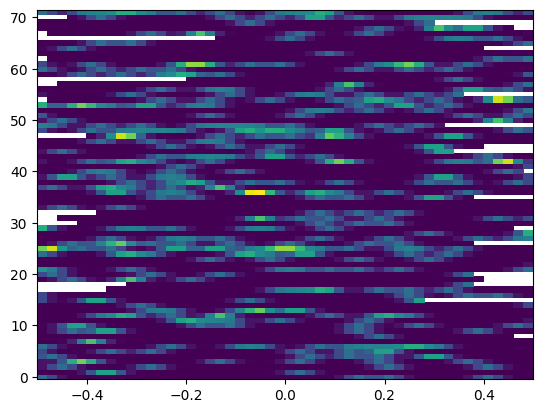

In [694]:
plt.pcolor(time_scaled,np.arange(x.shape[0]),x)


## to create a shuffle value function 
1. roll the values on each trial with a random number 
2. get the correlation with a shuffled x and y array 
3. repeat the procedure for 500 times get the correlation of all of them 
4. plot the histogram of the corr of all of the 500 times
5. get the 95% of the corr and compare that with the original correlation of the 2 array 

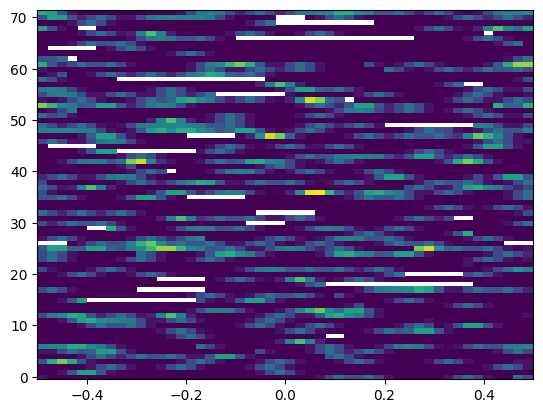

In [702]:
pair= pairs_sshank[10]
x = stackedifr_cells_normalized[trials_light_ids][:, pair[0]]
y = stackedifr_cells_normalized[trials_light_ids][:, pair[1]]

shifts = np.random.randint(0, x.shape[1], size=x.shape[0])
# Apply np.roll to each row with its corresponding shift
x_shuffle = np.array([np.roll(row, shift) for row, shift in zip(x, shifts)])
plt.pcolor(time_scaled,np.arange(x_shuffle.shape[0]),x_shuffle)


In [718]:
# calculate the Original Cor between the two time-maps 
# Replace NaNs with 0 in x and y
x_ = np.nan_to_num(x)
y_ = np.nan_to_num(y)
corr, corr_times = corr_norm_2d(x_, y)
corOriginal= np.max(corr)

/tmp/ipykernel_853601/29706544.py:6: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)


# Write a func to get the 99% value of the shuffling data 

In [712]:
percentile= 0.99
pair= pairs_sshank[10]
x = stackedifr_cells_normalized[trials_light_ids][:, pair[0]]
y = stackedifr_cells_normalized[trials_light_ids][:, pair[1]]

Corrs=[]
for i in range(400):
    shifts = np.random.randint(0, x.shape[1], size=x.shape[0])
    # Apply np.roll to each row with its corresponding shift
    x_shuffle = np.array([np.roll(row, shift) for row, shift in zip(x, shifts)])
    # Replace NaNs with 0 in x and y
    x_ = np.nan_to_num(x_shuffle)
    y_ = np.nan_to_num(y)

    corr, corr_times = corr_norm_2d(x_, y)
    Corrs.append(np.max(corr))

## get the 99% of the shuffled value 
shufVal= np.percentile(Corrs,percentile)

/tmp/ipykernel_853601/29706544.py:6: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)


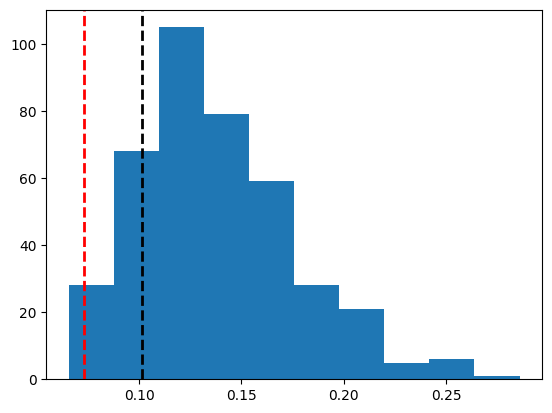

In [717]:
plt.hist(Corrs)
plt.axvline(shufVal, color='red', linestyle='--', linewidth=2, label=f'99th Percentile ({shufVal:.2f})')
plt.axvline(corOriginal,color='black', linestyle='--', linewidth=2, label=f'Corr. ({corOriginal:.2f})')

In [720]:
def Get_shuffled_correlation_forPairs(stackedifr_cells_normalized, pair, percentile= 0.99, iterations=500): 
    
    ## get the stack for the two cells in each pair
    x = stackedifr_cells_normalized[trials_light_ids][:, pair[0]] ## fs cell
    y = stackedifr_cells_normalized[trials_light_ids][:, pair[1]] ## this is the grid cell 
    
    ## get the original corr between the two stackedif
    x_ = np.nan_to_num(x)
    y_ = np.nan_to_num(y)
    corr, corr_times = corr_norm_2d(x_, y)
    corOriginal= np.max(corr)
    
    ### get the 99% of the shuffled value 
    Corrs=[]
    for i in range(iterations):
        shifts = np.random.randint(0, x.shape[1], size=x.shape[0])
        # Apply np.roll to each row with its corresponding shift
        x_shuffle = np.array([np.roll(row, shift) for row, shift in zip(x, shifts)])
        # Replace NaNs with 0 in x and y
        x_ = np.nan_to_num(x_shuffle)
        y_ = np.nan_to_num(y)

        corr, corr_times = corr_norm_2d(x_, y)
        Corrs.append(np.max(corr))

    ## get the 99% of the shuffled value 
    shufVal= np.percentile(Corrs,percentile)
    
    return corOriginal, shufVal

In [721]:
corOriginal, shufVal = Get_shuffled_correlation_forPairs(stackedifr_cells_normalized, pair, percentile= 0.99, iterations=500)

/tmp/ipykernel_853601/29706544.py:6: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)


In [722]:
corOriginal, shufVal

(0.10155930457628434, 0.07349882588137155)

## Try that on all the pairs in one session check if this is a good method seperateing the connected cells 

In [752]:
total_pairs = 0  # Initialize a counter for the total number of pairs

# Initialize the list to store all results
data = []

# Iterate over each hemisphere
for h in hems:
    # Iterate over each shank
    for sh in shanks:
        # Filter cells by shank and hemisphere
        sameshank_cells = session_cells[(session_cells.shank == sh) & (session_cells.cell_hemishphere == h)]
        othershank_cells = session_cells[~session_cells.cluId.isin(sameshank_cells.cluId)]

        # Get the FS and Grid cell indices
        fsin_indx = np.where((sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1 > 10))[0]
        gc_ssh_indx = np.where(sameshank_cells.gridCell_FIRST.values)[0]
        gc_othsh_indx = np.where(othershank_cells.gridCell_FIRST.values)[0]

        # Generate pairs
        pairs_sshank = list(product(fsin_indx, gc_ssh_indx))
        pairs_Othshank = list(product(fsin_indx, gc_othsh_indx))
        
        # Add the number of pairs from this iteration to the total
        total_pairs += len(pairs_sshank) + len(pairs_Othshank)
        
        sshank_corss = []
        for pair in tqdm(pairs_sshank):
            corOriginal, shufVal = Get_shuffled_correlation_forPairs(stackedifr_cells_normalized, pair, percentile=0.99, iterations=500)
            # Save the correlation values along with the pair indices
            sshank_corss.append({
                'fs_index': int(pair[0]),  # Index of the FS cell
                'gc_index': int(pair[1]),  # Index of the Grid cell
                'corOriginal': corOriginal,
                'shufVal': shufVal
            })
        
        Othshank_corss = []
        for pair in tqdm(pairs_Othshank):
            corOriginal, shufVal = Get_shuffled_correlation_forPairs(stackedifr_cells_normalized, pair, percentile=0.99, iterations=500)
            # Save the correlation values along with the pair indices
            Othshank_corss.append({
                'fs_index': int(pair[0]),  # Index of the FS cell
                'gc_index': int(pair[1]),  # Index of the Grid cell
                'corOriginal': corOriginal,
                'shufVal': shufVal
            })
        
        # Store the results in the data list
        data.append({
            'hemisphere': h,
            'shank': sh,
            'sshank_corss': sshank_corss,
            'Othshank_corss': Othshank_corss
        })

# After all iterations, print the total number of pairs
print(f"Total number of pairs processed: {total_pairs}")

flat_data = []

for entry in data:
    for cor in entry['sshank_corss']:
        flat_data.append({
            'hemisphere': entry['hemisphere'],
            'shank': entry['shank'],
            'pair_type': 'sshank',
            'fs_index': cor['fs_index'],
            'gc_index': cor['gc_index'],
            'corOriginal': cor['corOriginal'],
            'shufVal': cor['shufVal']
        })
    for cor in entry['Othshank_corss']:
        flat_data.append({
            'hemisphere': entry['hemisphere'],
            'shank': entry['shank'],
            'pair_type': 'Othshank',
            'fs_index': cor['fs_index'],
            'gc_index': cor['gc_index'],
            'corOriginal': cor['corOriginal'],
            'shufVal': cor['shufVal']
        })
        
df_pairs_sessions = pd.DataFrame(flat_data)

  0%|                                                                           | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_853601/29706544.py:6: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)
  7%|████▉                                                              | 4/54 [00:07<01:38,  1.97s/it]/tmp/ipykernel_853601/29706544.py:14: RuntimeWarning: Mean of empty slice
  C = np.nanmean([corr_norm(a,b) for a,b in zip(A,B)], axis=0)
100%|██████████████████████████████████████████████████████████████████| 26/26 [00:49<00:00,  1.91s/it]

Total number of pairs processed: 280


In [759]:
# Add the 'connected' column based on the condition
df_hemispher_sessions['connected'] = df_hemispher_sessions['shufVal'] < df_hemispher_sessions['corOriginal']


In [763]:
df_hemispher_sessions

,hemisphere,shank,pair_type,fs_index,gc_index,corOriginal,shufVal,connected
0,right,1,sshank,7,26,0.083593,0.045384,True
1,right,1,sshank,7,32,0.068028,0.036294,True
2,right,1,sshank,7,39,0.045654,0.033439,True
3,right,1,sshank,21,26,0.105544,0.048081,True
4,right,1,sshank,21,32,0.053549,0.034148,True
...,...,...,...,...,...,...,...,...
275,left,0,Othshank,18,96,0.055522,0.030046,True
276,left,0,Othshank,18,97,0.055234,0.037614,True
277,left,0,Othshank,18,99,0.109565,0.042045,True
278,left,0,Othshank,18,102,0.084132,0.032837,True


In [762]:
np.sum(df_hemispher_sessions.connected)

273

In [742]:
df_hemispher_sessions.shape, total_pairs

((280, 7), 280)

## Debuging 

In [146]:
sesName= 'jp486-09032023-0108'
sSesind= [sSes.name for sSes in sSessions].index(sesName)
print(sSesind)
sSes= sSessions[sSesind]
ses= myProject.sessionList[sSesind]


152


In [147]:
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

In [148]:
session_cells = cells[(cells.session == sSes.name)]
gc_indx = session_cells.gridCell_FIRST.values
fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values

cell_filters = [fsin_indx, gc_indx]
cell_filters_str = ['FSIN', 'GC']

light_conditions = [trials_light_ids, trials_dark_ids]
light_conditions_str = ['light', 'dark']

neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))

# Normalize the data
stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)


In [149]:
stackedifr_cells_normalized.shape

(145, 140, 50)

In [150]:
len(trials_light_ids), len(trials_dark_ids)

(72, 73)

In [151]:
light_condition = trials_light_ids
cell_filter = gc_indx

In [152]:
ifrstack = stackedifr_cells_normalized[light_condition][:, cell_filter]

In [153]:
ifrstack.shape

(72, 20, 50)

In [154]:
fsin_indx_ = np.where(fsin_indx)[0]
gc_indx_ = np.where(gc_indx)[0]

In [155]:
fs_gc_pairs = list(product(fsin_indx_, gc_indx_))
len(fs_gc_pairs)

280

In [156]:
ifrstack = stackedifr_cells_normalized[light_condition][:, cell_filter]

In [157]:
t_list = []
v_list = []
corr_list = []
corr_times_list = []

# Loop through each pair of FSIN and GC neurons
for fsindx, gcindx in tqdm(fs_gc_pairs):
    x = stackedifr_cells_normalized[light_condition][:, fsindx]
    y = stackedifr_cells_normalized[light_condition][:, gcindx]

    x_ = x.copy()
    y_ = y.copy()
    x_[np.isnan(x_)] = 0
    y_[np.isnan(y_)] = 0

    # Compute correlation and times
    corr, corr_times = corr_norm_2d(x_, y_)
    corr_times = corr_times * bin_size_sec
    
    # Store the results
    corr_list.append(corr)
    corr_times_list.append(corr_times)
    
    # Find the time and value of the peak correlation
    t = corr_times[np.argmax(corr)]
    v = np.max(corr)
    t_list.append(t)
    v_list.append(v)

# Convert t_list and v_list to numpy arrays
t_list = np.array(t_list)
v_list = np.array(v_list)


  0%|                                                                                             | 0/280 [00:00<?, ?it/s]/tmp/ipykernel_660006/3522171849.py:6: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)
100%|██████████████████████████████████████████████████████████████████████████████████| 280/280 [00:01<00:00, 275.39it/s]


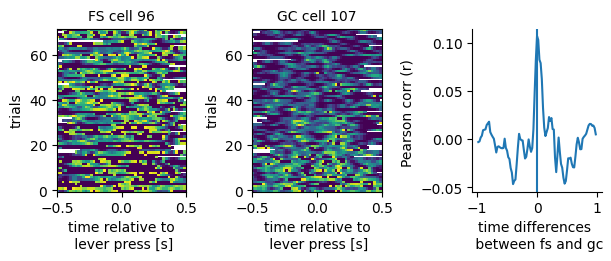

In [159]:
ncols = 3
rowSize, colSize = 2.5,2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)


fsindx,gcindx = fs_gc_pairs[171]

x = stackedifr_cells_normalized[light_condition][:, fsindx]
y = stackedifr_cells_normalized[light_condition][:, gcindx]

x_ = x.copy()
y_ = y.copy()
x_[np.isnan(x_)]=0
y_[np.isnan(y_)]=0

ax= fig.add_subplot(gs[0])
ax.pcolor(time_scaled,np.arange(x.shape[0]),x)
ax.set_xlabel("time relative to\n lever press [s]")
ax.set_ylabel("trials")
ax.set_title("FS cell {}".format(fsindx), fontsize= 10)
#plt.imshow(y)

ax= fig.add_subplot(gs[1])
ax.pcolor(time_scaled,np.arange(y.shape[0]),y)
ax.set_xlabel("time relative to\n lever press [s]")
ax.set_ylabel("trials")
ax.set_title("GC cell {}".format(gcindx), fontsize= 10)


ax= fig.add_subplot(gs[2])
corr, corr_times = corr_norm_2d(x_,y_)
corr_times=corr_times*bin_size_sec
t = corr_times[np.argmax(corr)]
v = np.max(corr)
ax.plot(corr_times, corr)
ax.axvline(t)

ax.set_xlabel('time differences \n between fs and gc')
ax.set_ylabel('Pearson corr (r) ')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


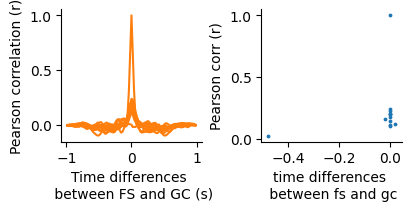

In [134]:

nrows= 1
ncols = 2
rowSize, colSize = 2,2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

ax= fig.add_subplot(gs[0])
for i, (corr_times, corr) in enumerate(zip(corr_times_list, corr_list)):
    ax.plot(corr_times, corr, label="FS {}, GC {}".format(fs_gc_pairs[i][0], fs_gc_pairs[i][1]))

ax.set_xlabel('Time differences \n between FS and GC (s)')
ax.set_ylabel('Pearson correlation (r)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax= fig.add_subplot(gs[1])
ax.scatter(t_list,v_list, s= 3)
ax.set_xlabel('time differences \n between fs and gc')
ax.set_ylabel('Pearson corr (r)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [103]:
def pcorr(a,b):
    r,p=pearsonr(a.flatten(),b.flatten())
    return r

def normalize_zscore(x):
    return (x-np.mean(x))/np.std(x)

def corr_norm(x,y,mode="full"):
    x_=normalize_zscore(x)
    y_=normalize_zscore(y)
    return np.correlate(x_,y_,mode=mode)/len(x)
    
def corr_norm_2d(A,B):
    C = np.mean([corr_norm(a,b) for a,b in zip(A,B)], axis=0)
    shifts = np.arange(len(C))-len(C)//2
    return C, shifts
    
#plt.plot(shifts, C)

  0%|                                                                                             | 0/280 [00:00<?, ?it/s]/tmp/ipykernel_660006/3522171849.py:6: RuntimeWarning: invalid value encountered in divide
  return (x-np.mean(x))/np.std(x)
100%|██████████████████████████████████████████████████████████████████████████████████| 280/280 [00:01<00:00, 233.18it/s]


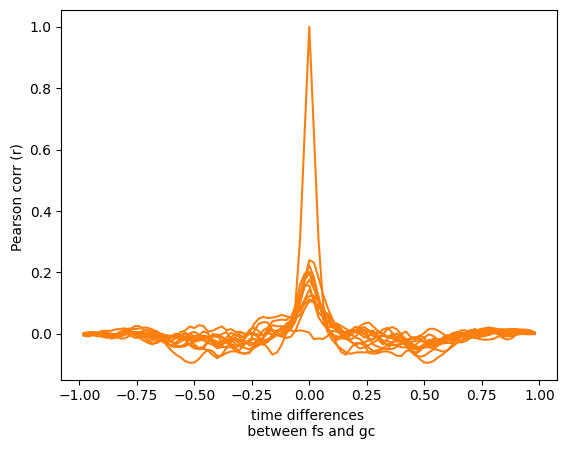

In [ ]:
t_list=[]
v_list=[]
corr_list=[]

for fsindx,gcindx in tqdm(fs_gc_pairs):
    x = stackedifr_cells_normalized[light_condition][:, fsindx]
    y = stackedifr_cells_normalized[light_condition][:, gcindx]

    x_ = x.copy()
    y_ = y.copy()
    x_[np.isnan(x_)]=0
    y_[np.isnan(y_)]=0

    #corr = signal.correlate2d(x_,y_, boundary='fill', mode='full')
    #corr = corr[corr.shape[0]//2]
    #corr_times = (np.arange(len(corr))-len(corr)//2)*bin_size_sec
    
    corr, corr_times = corr_norm_2d(x_,y_)
    corr_list.append(corr)
    corr_times=corr_times*bin_size_sec
    t = corr_times[np.argmax(corr)]
    v = np.max(corr)
    t_list.append(t)
    v_list.append(v)
    
    plt.plot(corr_times, corr, label="FS {}, GC {}".format(fsindx,gcindx))
    plt.xlabel('time differences \n between fs and gc')
    plt.ylabel('Pearson corr (r) ')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
t_list=np.array(t_list)
v_list=np.array(v_list)

In [105]:
np.where(~np.isnan(v_list))

(array([ 11,  31,  51,  71,  91, 111, 131, 151, 171, 191, 211, 231, 251]),)

In [107]:
np.argsort(v_list)

array([191, 171,  31,  51, 231, 131, 251, 151,  91, 111,  11,  71, 211,
       185, 183, 182, 186, 187, 188, 181, 189, 184, 192, 180, 206, 205,
       204, 203, 202, 201, 190, 200, 198, 197, 196, 195, 194, 193, 199,
       179, 175, 177, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155,
       156, 157, 158, 159, 178, 160, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 172, 173, 174, 207, 176, 161, 208,   0, 210, 247, 248,
       249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 246,
       262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 263, 245, 244, 243, 144, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 242, 241, 240,
       239, 238, 237, 209, 236, 234, 233, 232, 230, 229, 228, 235, 143,
       139, 141,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  36,  52,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  53,  68,  35,  33,   1,   

In [358]:
t_list=np.array(t_list)
v_list=np.array(v_list)

Text(0, 0.5, 'Pearson corr (r) for each pair')

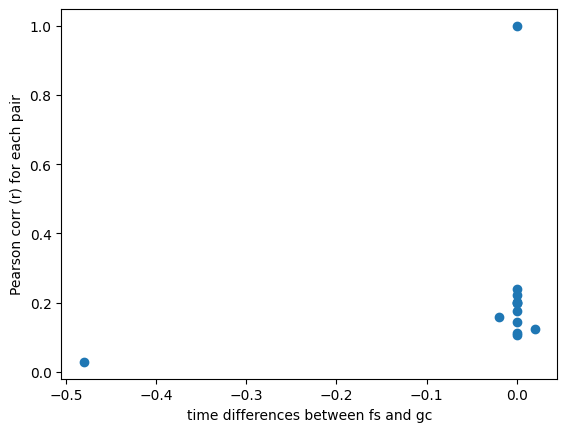

In [359]:
plt.scatter(t_list,v_list)
plt.xlabel('time differences between fs and gc')
plt.ylabel('Pearson corr (r) for each pair')

In [218]:
expected_value(t_list, v_list)

-0.004905054304700945

## Get the cross correlation between this cells and the gc pairs

In [ ]:
fsid= session_cells[(session_cells.interneuron) & (session_cells.mrate_RF1 > 10)].iloc[1].cluId
gcids= session_cells[session_cells.gridCell_FIRST].cluId

sSes,ses,fsn, fsid = get_sSesId_nId(fsid)
sSes,ses,gcn, gcid = get_sSesId_nId(gcids.iloc[1])

######
session_trials = res[(res.sessionName == sSes.name) & (res.valid==True) & (res.light=='light')].sort_values(by='trialNo')
LeverPressinRestime = session_trials.levertimeRes.values
intervals = [(v-0.5, v + 0.5) for v in LeverPressinRestime]
#atLever_times = np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']])

min_sec=-0.05; max_sec=0.05; bin_size_sec=0.001

for start, end in intervals:
    #print(start,end)
    fsn.spike_train.set_intervals(np.array([start,end]))
    gcn.spike_train.set_intervals(np.array([start,end]))
    
    ## get the crossCorr 
    hist,edges = n.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st, bin_size_sec=bin_size_sec, min_sec=min_sec, max_sec=max_sec)
    timestamp = n.spike_train.mid_point_from_edges(edges)


In [ ]:
#plt.bar(timestamp, hist, width=bin_size_sec)     

Text(0, 0.5, 'Spike count')

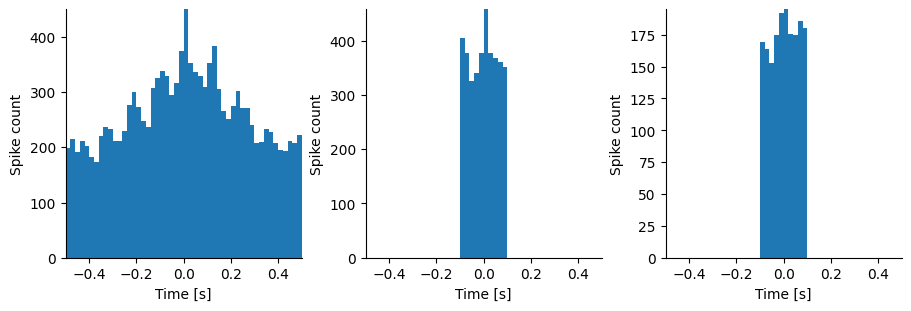

In [ ]:
col = 3
row = 1
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

min_sec=-0.5; max_sec=0.5; bin_size_sec=0.02
ax= fig.add_subplot(gs[0])
sSes,ses,gcn, gcid = get_sSesId_nId(gcids.iloc[1])
gcn.spike_train.set_intervals(ses.intervalDict['atLever_light'])
fsn.spike_train.set_intervals(ses.intervalDict['atLever_light'])
hist,edges = n.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st, bin_size_sec=bin_size_sec, min_sec=min_sec, max_sec=max_sec)
#hist,edges = n.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st, bin_size_sec=bin_size_sec)
timestamp = n.spike_train.mid_point_from_edges(edges)

ax.bar(timestamp, hist, width=bin_size_sec)     
ax.set_xlim(min_sec, max_sec)
ax.set_ylim(0,np.max(hist))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Spike count")

ax= fig.add_subplot(gs[1])
sSes,ses,gcn, gcid = get_sSesId_nId(gcids.iloc[1])
gcn.spike_train.unset_intervals()
fsn.spike_train.unset_intervals()

gcn.spike_train.set_intervals(ses.intervalDict['light'])
fsn.spike_train.set_intervals(ses.intervalDict['light'])
#hist,edges = n.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st, bin_size_sec=bin_size_sec, min_sec=min_sec, max_sec=max_sec)
hist,edges = n.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st, bin_size_sec=bin_size_sec)
timestamp = n.spike_train.mid_point_from_edges(edges)

ax.bar(timestamp, hist, width=bin_size_sec)    
ax.set_xlim(min_sec, max_sec)
ax.set_ylim(0,np.max(hist))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Spike count")


ax= fig.add_subplot(gs[2])
sSes,ses,gcn, gcid = get_sSesId_nId(gcids.iloc[1])
gcn.spike_train.unset_intervals()
fsn.spike_train.unset_intervals()

gcn.spike_train.set_intervals(ses.intervalDict['searchPath_light'])
fsn.spike_train.set_intervals(ses.intervalDict['searchPath_light'])
#hist,edges = n.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st, bin_size_sec=bin_size_sec, min_sec=min_sec, max_sec=max_sec)
hist,edges = n.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st, bin_size_sec=bin_size_sec)
timestamp = n.spike_train.mid_point_from_edges(edges)

ax.bar(timestamp, hist, width=bin_size_sec)    
ax.set_xlim(min_sec, max_sec)
ax.set_ylim(0,np.max(hist))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Spike count")

In [1110]:
ses.intervalDict.keys()

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_1', 'light_2', 'dark', 'dark_1', 'dark_2', 'trialNo', 'searchPath_light', 'searchPath_light_1', 'searchPath_light_2', 'searchPath_dark', 'searchPath_dark_1', 'searchPath_dark_2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingPath_light', 'homingPath_light_1', 'homingPath_light_2', 'homingPath_dark', 'homingPath_dark_1', 'homingPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_light_1', 'homingFromLeavingLeverToPeriphery_light_2', 'homingFromLeavingLeverToPeriphery_dark', 'homingFromLeavingLeverToPeriphery_dark_1', 'homingFromLeavingLeverT